In [20]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib as mpl
import IPython
IPython.display.set_matplotlib_formats('png2x')

In [6]:
# convenience function
def make_summary_cols(df, cat_threshold=20):
    types = df.dtypes
    types.name = 'dtypes'

    nuniques = data.nunique()
    nuniques.name = 'nuniques'

    nulls = df.isnull().sum()
    nulls.name = 'nulls'

    summary_cols = pd.merge(left=pd.merge(left=nuniques, right=types, left_index=True, right_index=True), right=nulls, left_index=True, right_index=True).sort_values(by='dtypes')
    summary_cols['isnumeric_column'] = summary_cols['dtypes'].apply(lambda x: False if x=='object' else True)

    summary_cols['probably_categorical'] = summary_cols['nuniques'].apply(lambda x: True if x <=cat_threshold else False)

    return summary_cols

def perc_on_bar(feature, data, figsize=[15,7],axes=None, hue=None):
    '''
    plot
    feature: categorical feature
    data: df to use
    figsize: set custom figsize
    axes: if setting up as multiplot
    hue: sns hue parameter
    '''
    #Creating a countplot for the feature
    sns.set(rc={'figure.figsize':tuple(figsize)})
    ax=sns.countplot(x=feature, data=data, ax=axes, hue=hue)
    
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.25 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 14) # annotate the percantage 
        
    #plt.show() # show the plot

def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram
    
    
def make_confusion_matrix(model,y_actual,labels=[1, 0], cmap='Blues'):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='', cmap=cmap)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    ##  Function to calculate accuracy score
    
def get_accuracy_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    c = [] # defining an empty list to store train and test results
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    c.append(train_acc) # adding train accuracy to list
    c.append(test_acc) # adding test accuracy to list
    if flag == True: # If the flag is set to True then only the following print statements will be dispayed
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
    
    return c # returning the list with train and test scores

In [7]:
data = pd.read_excel('Tourism.xlsx', sheet_name='Tourism')
data_dict = pd.read_excel('Tourism.xlsx', sheet_name='Data Dict', skiprows=0,usecols='B:D') #using table within sheet
data_dict.columns = data_dict.loc[0] # set column names
data_dict = data_dict.loc[1:] #drop first row as contained col names
a = list(data_dict.columns[0:2])+['Description'] #correct spelling of third column
data_dict.columns = a #as above


In [8]:
data.head()

,CustomerID,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Super Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Super Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Multi,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Multi,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Multi,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [9]:
data_dict

,Data,Variable,Description
1,Tourism,CustomerID,Unique customer ID
2,Tourism,ProdTaken,Product taken flag
3,Tourism,Age,Age of customer
4,Tourism,PreferredLoginDevice,Preferred login device of customer in last month
5,Tourism,CityTier,City tier
6,Tourism,DurationOfPitch,Duration of pitch by a sales man to customer
7,Tourism,Occupation,Occupation of customer
8,Tourism,Gender,Gender of customer
9,Tourism,NumberOfPersonVisited,Total number of person came with customer
10,Tourism,NumberOfFollowups,Total number of follow up has been done by sal...


In [10]:
data.shape


(4888, 20)

<font color=blue>
<li> 4888 rows and 19 columns in dataset (excluding the ID column which we will drop later)

In [11]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               4888 non-null   int64  
 1   ProdTaken                4888 non-null   int64  
 2   Age                      4662 non-null   float64
 3   PreferredLoginDevice     4863 non-null   object 
 4   CityTier                 4888 non-null   int64  
 5   DurationOfPitch          4637 non-null   float64
 6   Occupation               4888 non-null   object 
 7   Gender                   4888 non-null   object 
 8   NumberOfPersonVisited    4888 non-null   int64  
 9   NumberOfFollowups        4843 non-null   float64
 10  ProductPitched           4888 non-null   object 
 11  PreferredPropertyStar    4862 non-null   float64
 12  MaritalStatus            4888 non-null   object 
 13  NumberOfTrips            4748 non-null   float64
 14  Passport                

<font color=blue>
<li> quite a few nulls - will explore further on

In [12]:
data.describe()

,CustomerID,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
count,4888.000000,4888.000000,4662.000000,4888.000000,4637.000000,4888.000000,4843.000000,4862.000000,4748.000000,4888.000000,4888.000000,4888.000000,4822.000000,4655.000000
mean,202443.500000,0.188216,37.622265,1.654255,15.490835,2.905074,3.708445,3.581037,3.236521,0.290917,3.078151,0.620295,1.187267,23619.853491
std,1411.188388,0.390925,9.316387,0.916583,8.519643,0.724891,1.002509,0.798009,1.849019,0.454232,1.365792,0.485363,0.857861,5380.698361
min,200000.000000,0.000000,18.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000
25%,201221.750000,0.000000,31.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,20346.000000
50%,202443.500000,0.000000,36.000000,1.000000,13.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,1.000000,1.000000,22347.000000
75%,203665.250000,0.000000,44.000000,3.000000,20.000000,3.000000,4.000000,4.000000,4.000000,1.000000,4.000000,1.000000,2.000000,25571.000000
max,204887.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,5.000000,1.000000,3.000000,98678.000000


In [13]:
data.drop('CustomerID', axis=1,inplace=True)
data

,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Super Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Super Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Multi,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Multi,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Multi,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,1,49.0,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Super Deluxe,4.0,Unmarried,2.0,1,1,1,1.0,Manager,26576.0
4884,1,28.0,Company Invited,1,31.0,Salaried,Male,4,5.0,Multi,3.0,Single,3.0,1,3,1,2.0,Executive,21212.0
4885,1,52.0,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,Senior Manager,31820.0
4886,1,19.0,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Multi,3.0,Single,3.0,0,5,0,2.0,Executive,20289.0


<font color=blue>
<li>Dont need ID - dropping it

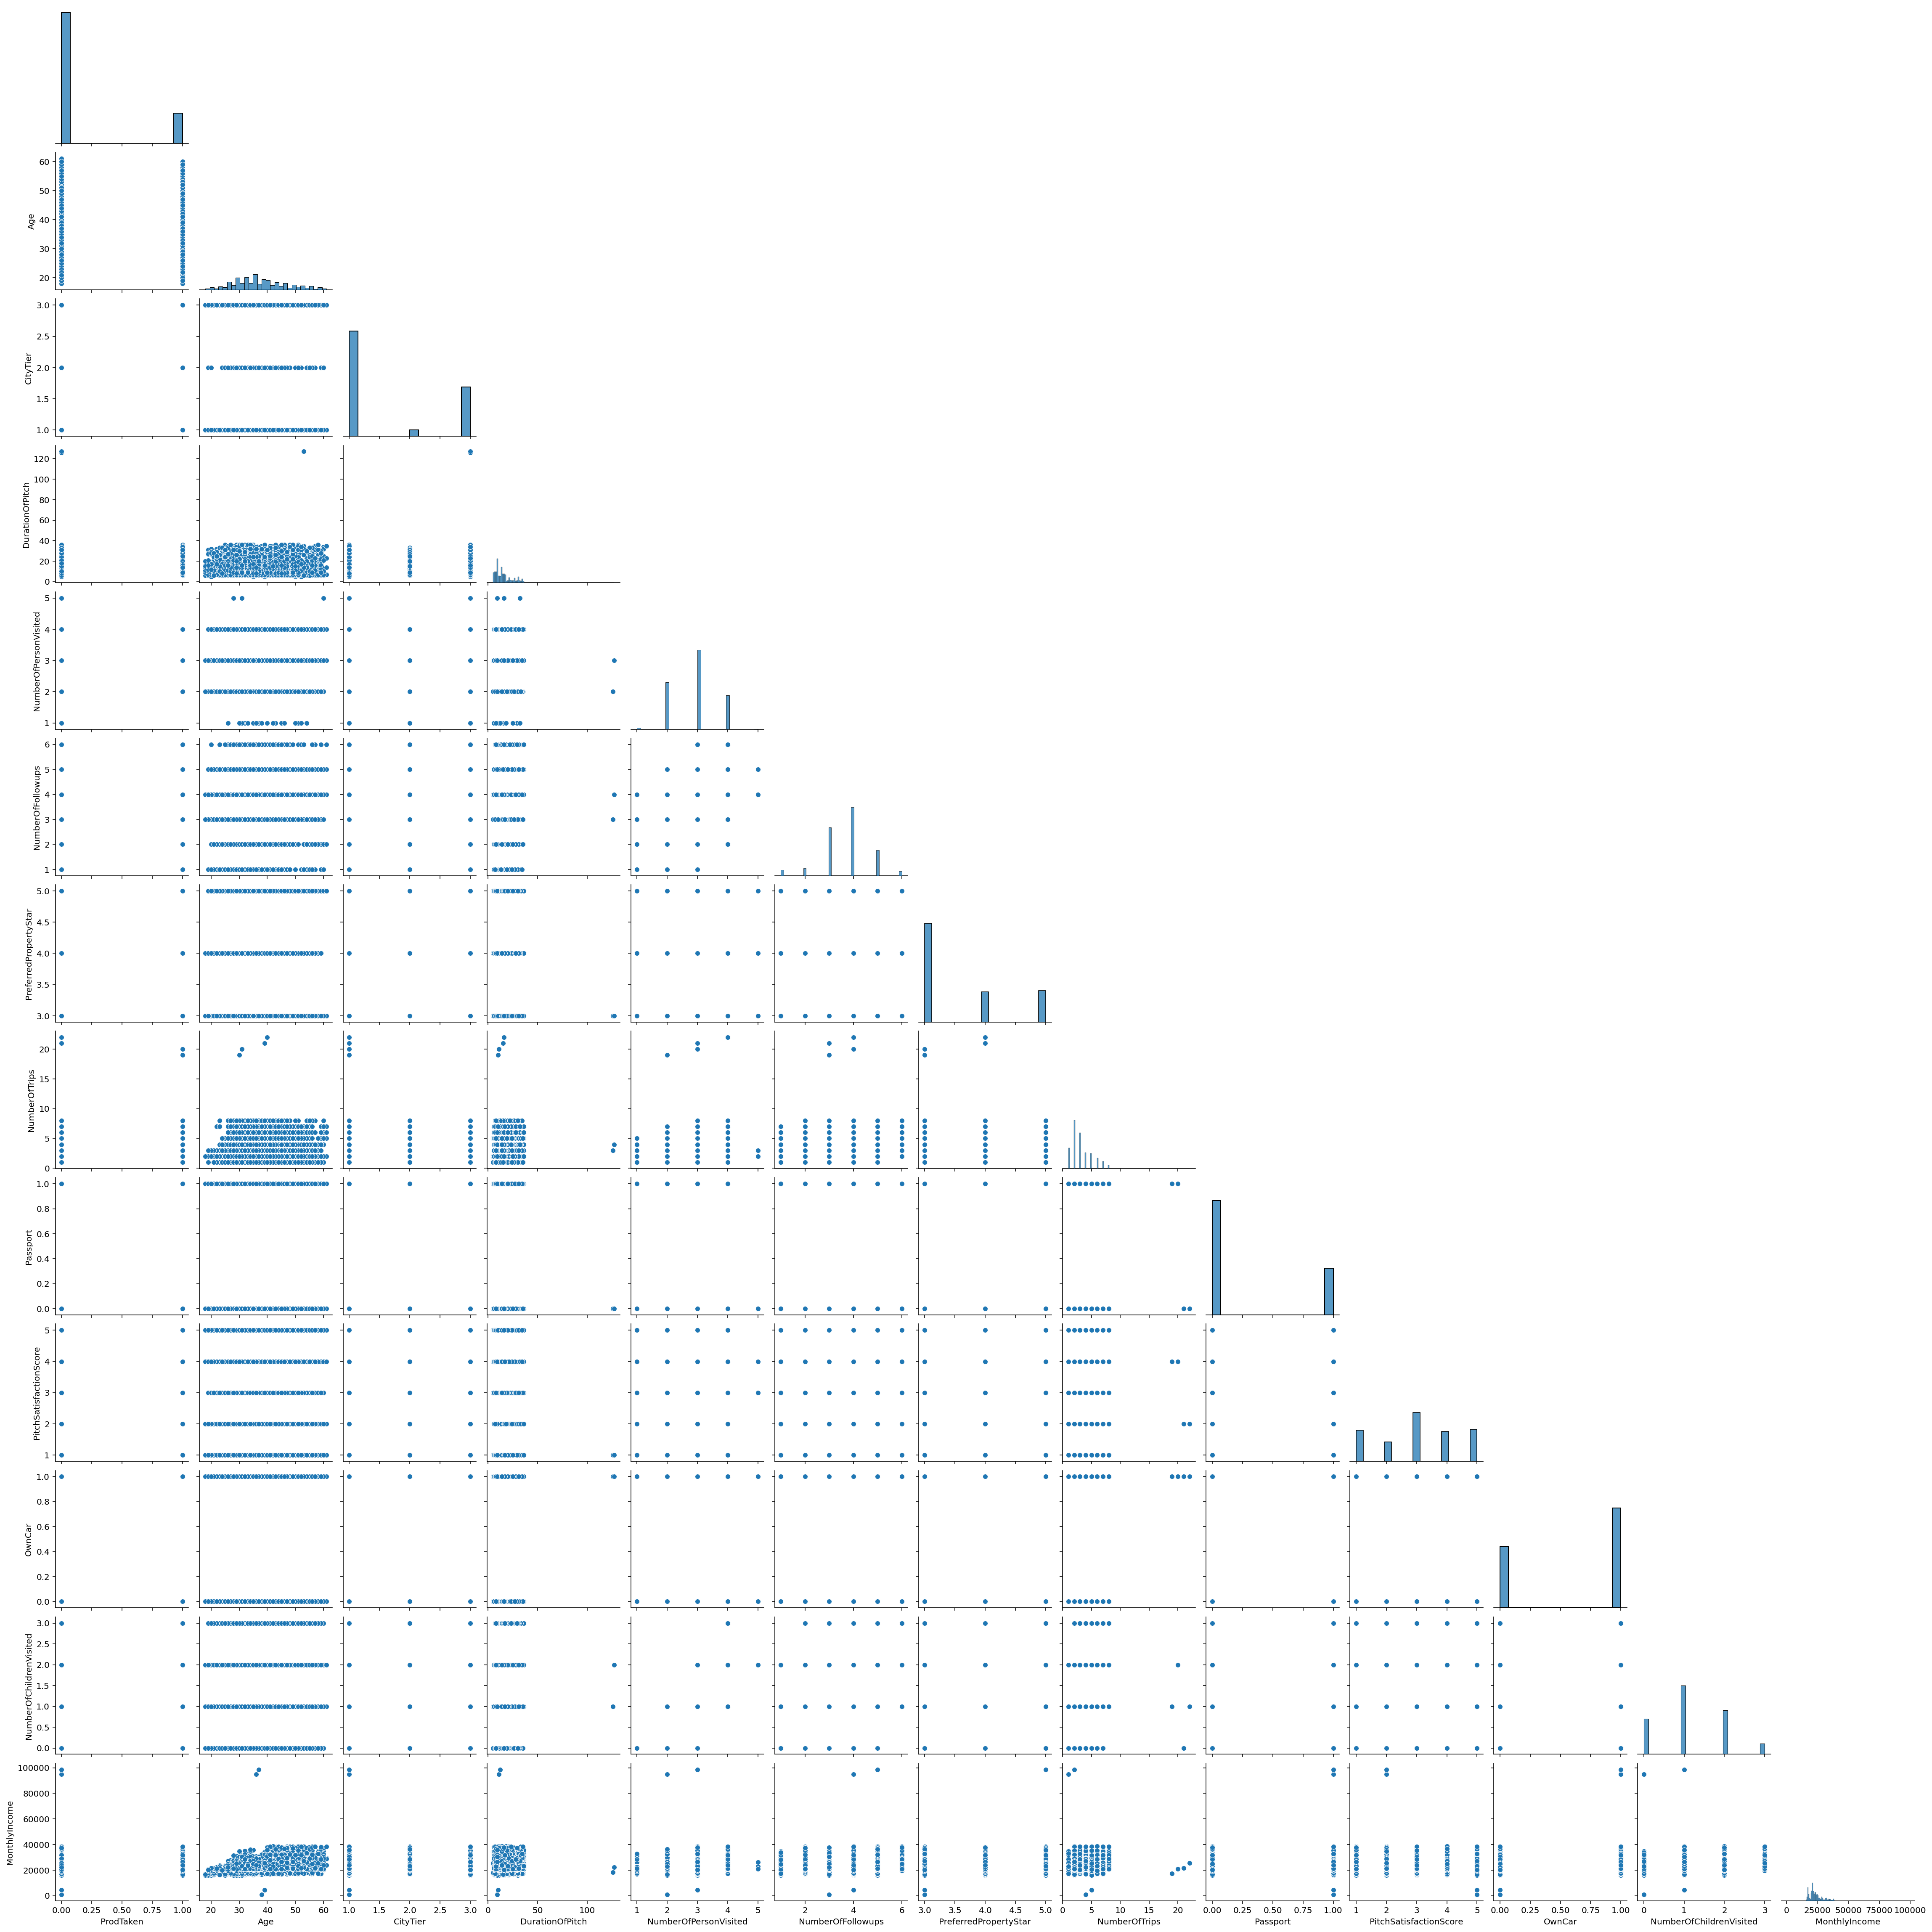

In [21]:
sns.pairplot(data, corner=True)

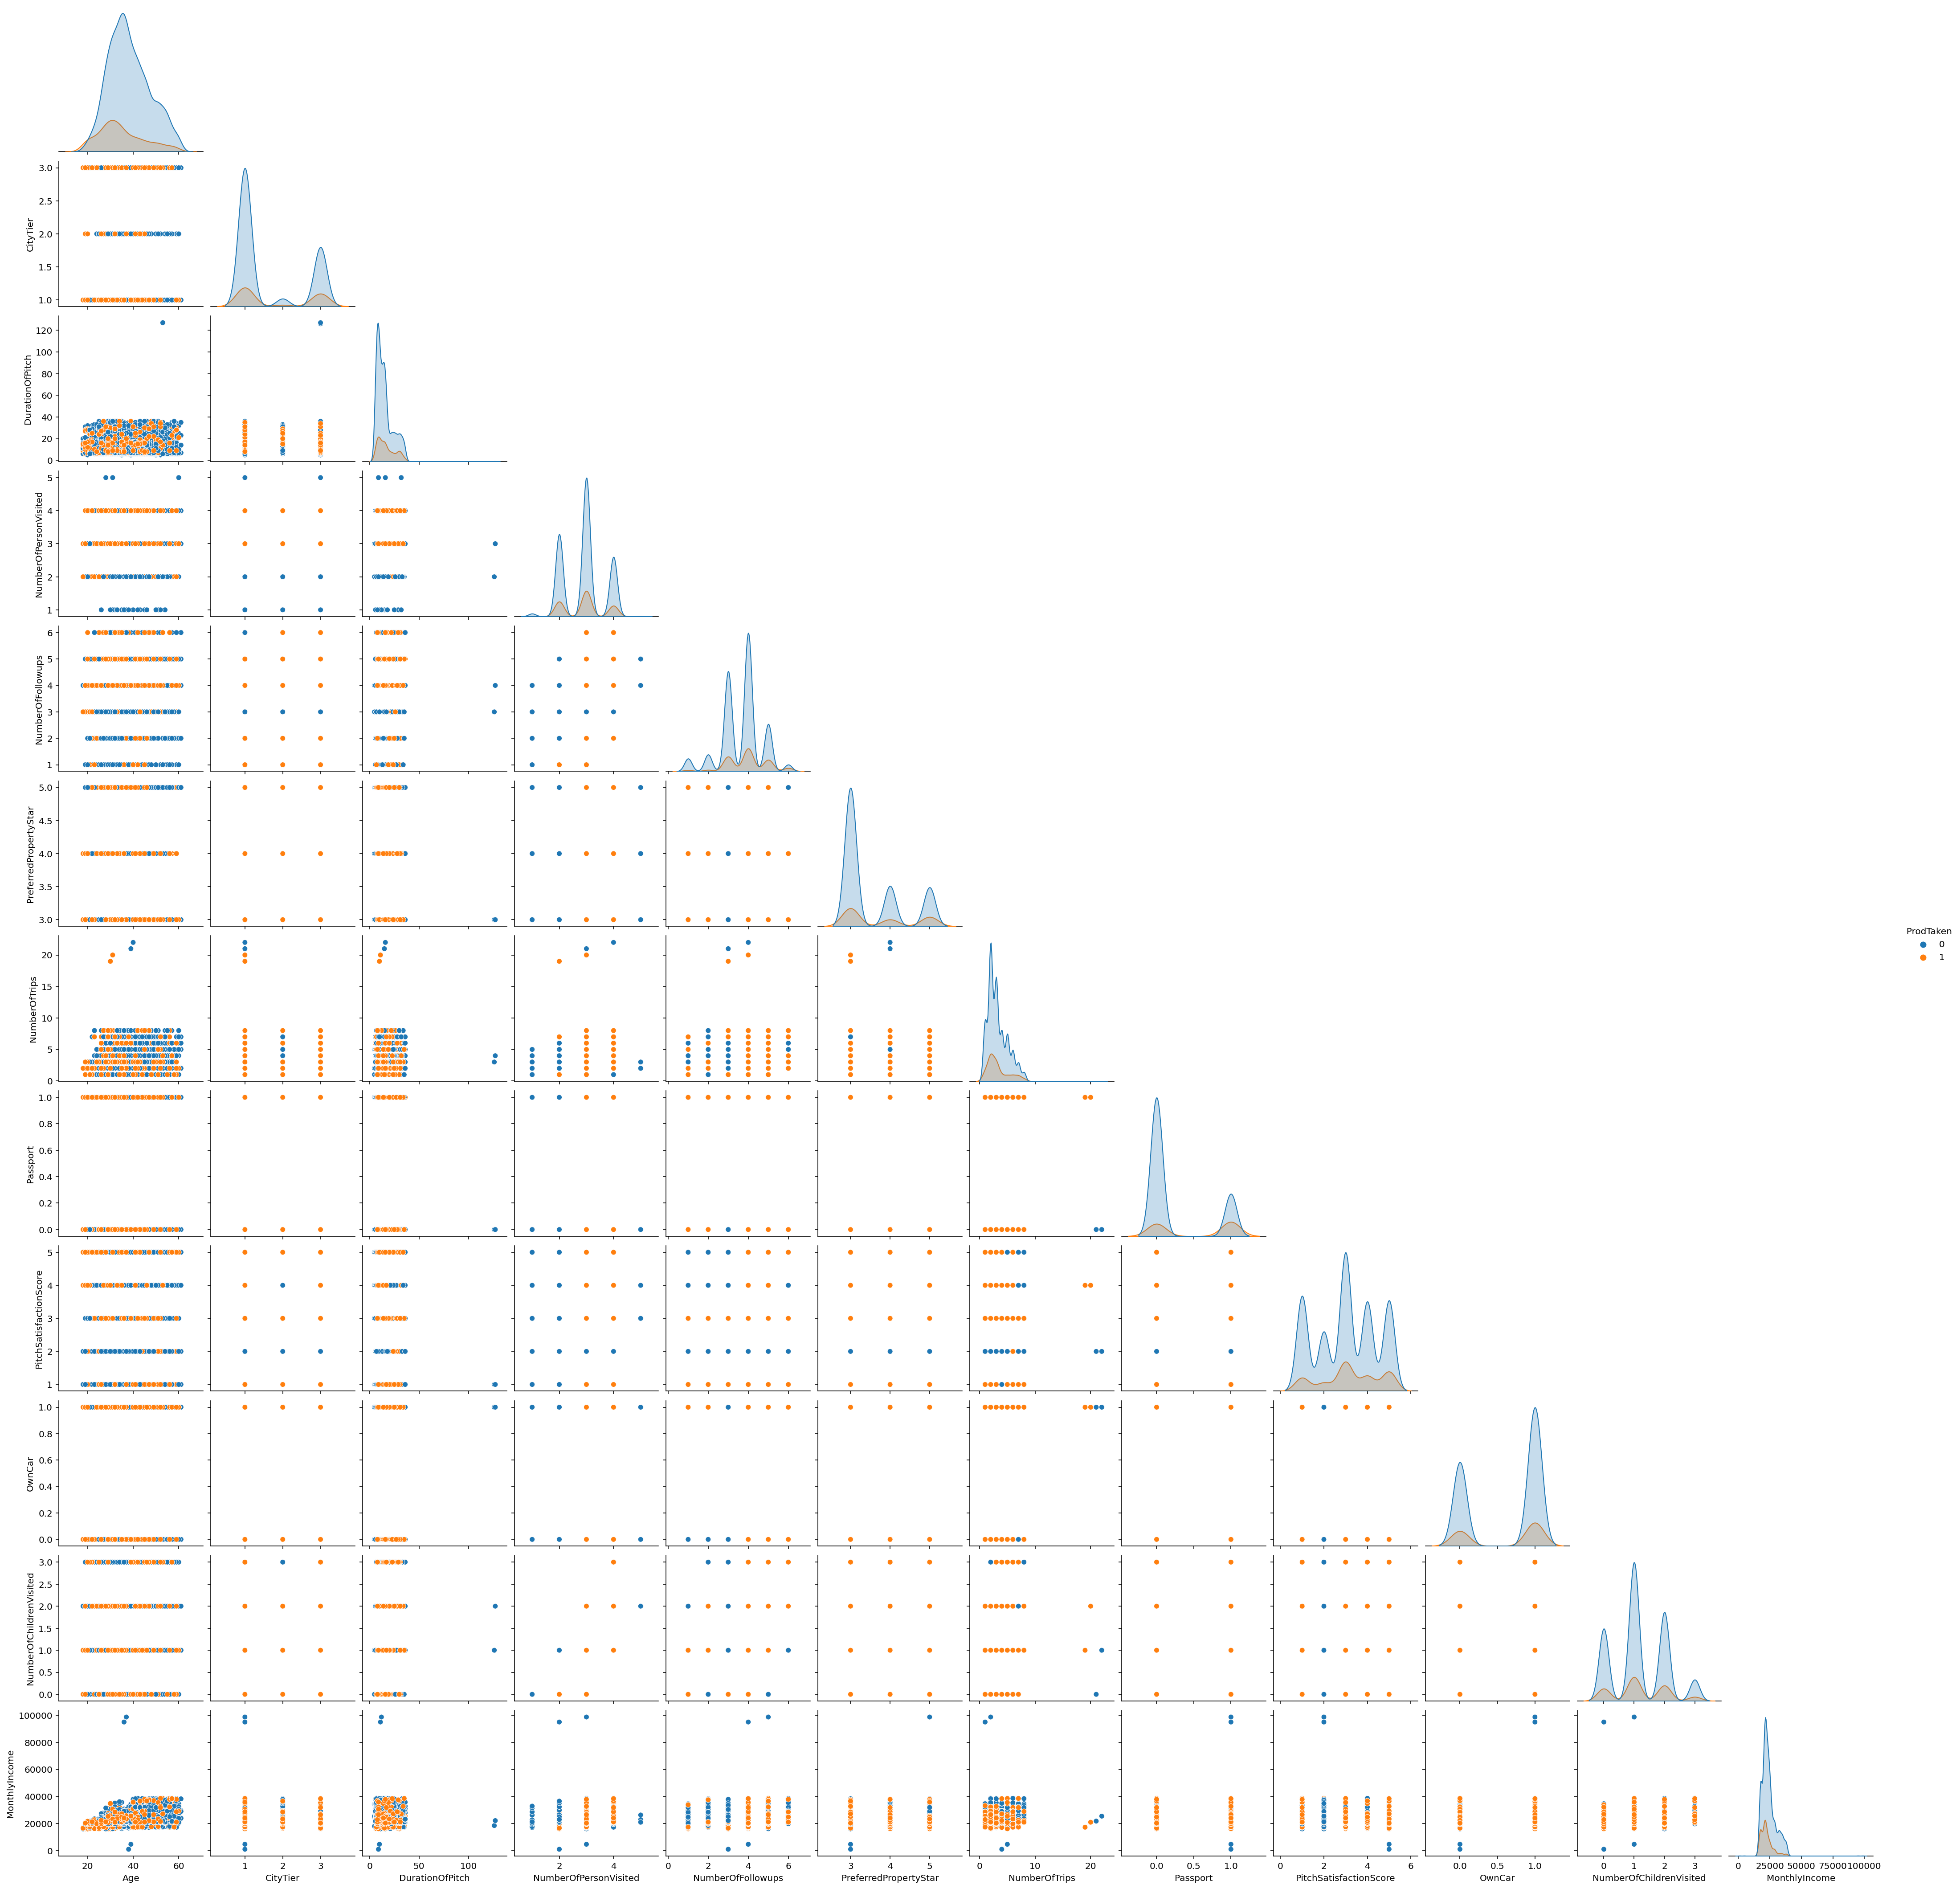

In [22]:
sns.pairplot(data, hue='ProdTaken', corner=True)

In [12]:
summary_cols = make_summary_cols(data)
display(summary_cols)
non_numeric_columns = list(summary_cols[summary_cols.isnumeric_column==False].index)
numeric_columns = list(summary_cols[summary_cols.isnumeric_column==True].index)


,nuniques,dtypes,nulls,isnumeric_column,probably_categorical
ProdTaken,2,int64,0,True,True
OwnCar,2,int64,0,True,True
CityTier,3,int64,0,True,True
PitchSatisfactionScore,5,int64,0,True,True
Passport,2,int64,0,True,True
NumberOfPersonVisited,5,int64,0,True,True
NumberOfChildrenVisited,4,float64,66,True,True
NumberOfTrips,12,float64,140,True,True
PreferredPropertyStar,3,float64,26,True,True
MonthlyIncome,2475,float64,233,True,False


<AxesSubplot:>

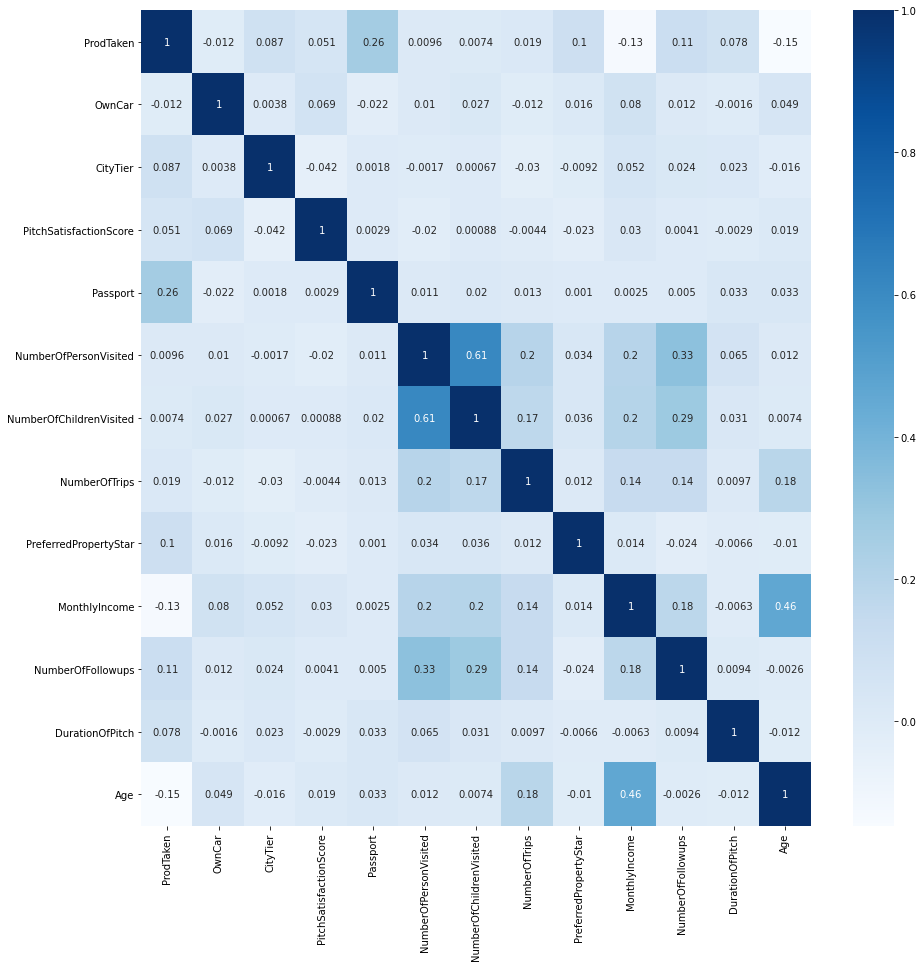

In [13]:
fig,axes = plt.subplots(figsize=(15,15))
sns.heatmap(data.loc[:,numeric_columns].corr(), annot=True, cmap='Blues')

In [14]:
data.corr()

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
ProdTaken,1.000000,-0.147254,0.086852,0.078257,0.009627,0.112171,0.099577,0.018898,0.260844,0.051394,-0.011508,0.007421,-0.130585
Age,-0.147254,1.000000,-0.015625,-0.012063,0.011621,-0.002577,-0.010474,0.184905,0.033399,0.018510,0.048654,0.007370,0.464869
CityTier,0.086852,-0.015625,1.000000,0.022703,-0.001671,0.023652,-0.009164,-0.029709,0.001793,-0.042160,0.003817,0.000672,0.051817
DurationOfPitch,0.078257,-0.012063,0.022703,1.000000,0.065141,0.009434,-0.006637,0.009715,0.033034,-0.002880,-0.001626,0.031408,-0.006252
NumberOfPersonVisited,0.009627,0.011621,-0.001671,0.065141,1.000000,0.328569,0.033867,0.195223,0.011177,-0.019581,0.010362,0.610621,0.195134
NumberOfFollowups,0.112171,-0.002577,0.023652,0.009434,0.328569,1.000000,-0.024176,0.139517,0.004970,0.004054,0.012112,0.286425,0.176503
PreferredPropertyStar,0.099577,-0.010474,-0.009164,-0.006637,0.033867,-0.024176,1.000000,0.012115,0.001040,-0.022701,0.015742,0.035798,0.014289
NumberOfTrips,0.018898,0.184905,-0.029709,0.009715,0.195223,0.139517,0.012115,1.000000,0.012949,-0.004378,-0.011825,0.168795,0.139105
Passport,0.260844,0.033399,0.001793,0.033034,0.011177,0.004970,0.001040,0.012949,1.000000,0.002926,-0.022330,0.020264,0.002545
PitchSatisfactionScore,0.051394,0.018510,-0.042160,-0.002880,-0.019581,0.004054,-0.022701,-0.004378,0.002926,1.000000,0.068850,0.000878,0.030421


<font color = blue>
<li> only significant corr between monthlyincome and age and number of person visited and number of children visited
<li> also some corr between number of followups and no of people visited 

<font color=blue>
<li> Almost all columns seem to be categorical (limited no of values) except MonthlyIncome, DurationOfPitch and Age (all 3 are somewhat right skewed as mean > median)
<li> Nulls in NumberOfChildrenVisited, NumberOfTrips, PreferredPropertyStar, MonthlyIncome, NumberOfFollowups, DurationOfPitch, Age, PreferredLoginDevice
<li>MaritalStatus to ProductPitched are columns with non numeric data (for trees even for categorical numeric data we can leave without one hot encoding, however have to one hot encode columns with non numeric data)

In [15]:
d = {}
for column in list(summary_cols[summary_cols.probably_categorical==True].index):
    #print(column)
    #data[column] = data[column].astype(np.cate .categorical)
    #print(data[column].unique())
    d[column]=data[column].unique()

for key in d:
    print(f'{key}: {d[key]}')


ProdTaken: [1 0]
OwnCar: [1 0]
CityTier: [3 1 2]
PitchSatisfactionScore: [2 3 5 4 1]
Passport: [1 0]
NumberOfPersonVisited: [3 2 1 4 5]
NumberOfChildrenVisited: [ 0.  2.  1. nan  3.]
NumberOfTrips: [ 1.  2.  7.  5.  6.  3.  4. 19. 21.  8. nan 20. 22.]
PreferredPropertyStar: [ 3.  4.  5. nan]
NumberOfFollowups: [ 3.  4.  2.  5. nan  1.  6.]
MaritalStatus: ['Single' 'Divorced' 'Married' 'Unmarried']
Gender: ['Female' 'Male' 'Fe Male']
Occupation: ['Salaried' 'Free Lancer' 'Small Business' 'Large Business']
PreferredLoginDevice: ['Self Enquiry' 'Company Invited' nan]
Designation: ['Manager' 'Executive' 'Senior Manager' 'AVP' 'VP']
ProductPitched: ['Super Deluxe' 'Multi' 'Standard' 'Deluxe' 'King']


<font color=Blue>
<li> Examining uniques for categorical columns

In [16]:
# Fixing Gender
data.Gender = data.Gender.apply(lambda x: 'Female' if x=='Fe Male' else x)
data.Gender.unique()

array(['Female', 'Male'], dtype=object)

<font color=blue>
<li> Fixing Female mis typed entries as will distort bivariate analysis below

<font color=Blue>
<h4> Visualisations - Continuous/ Discrete Non Categorical

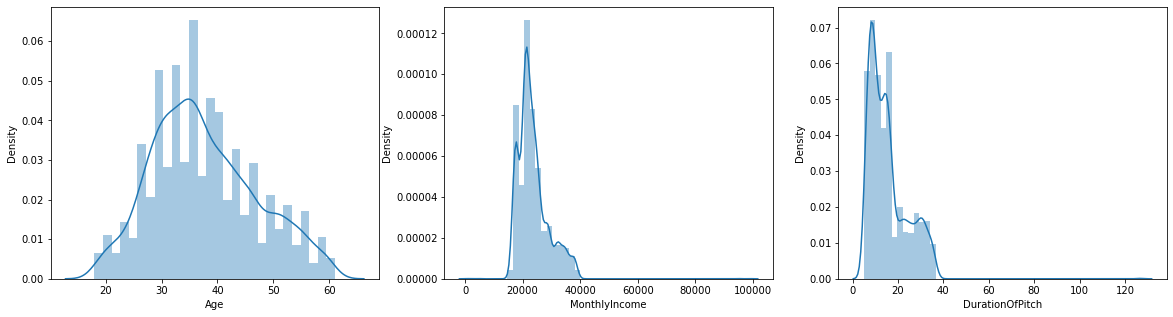

In [17]:
fig, axes = plt.subplots(1,3, figsize=(20,5))
for i,col in enumerate(['Age', 'MonthlyIncome', 'DurationOfPitch']):
    sns.distplot(data[col], ax=axes[i])
    #plt.show()

<font color=Blue>
<h4> Visualisations - Continuous/ Discrete non Categorical, Bivariate

No handles with labels found to put in legend.
No handles with labels found to put in legend.


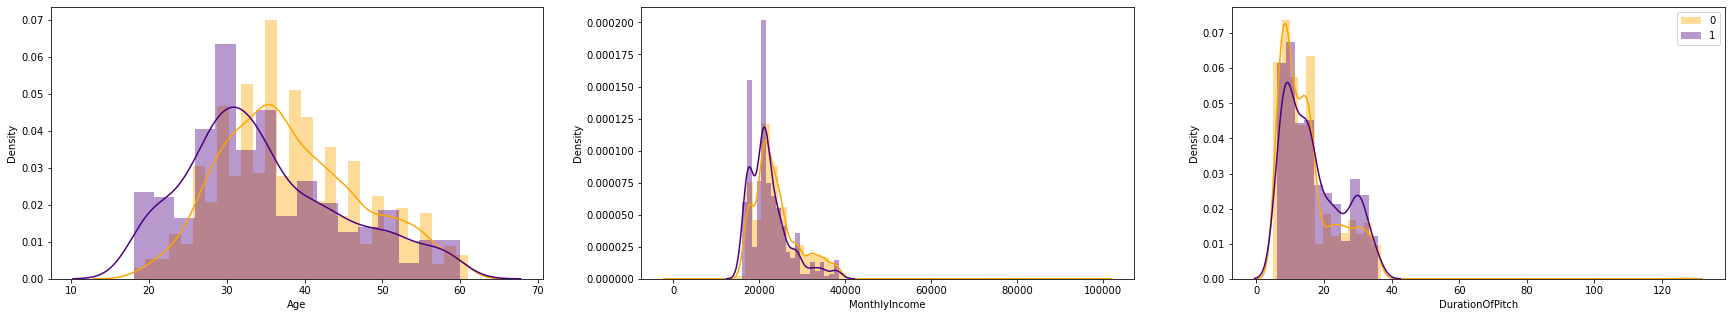

In [18]:
fig, axes = plt.subplots(1,3, figsize=(30,5))
for i,col in enumerate(['Age', 'MonthlyIncome', 'DurationOfPitch']):
    sns.distplot(data[data['ProdTaken']==0][col],color='orange',label=0, ax=axes[i])
    sns.distplot(data[data['ProdTaken']==1][col],color='indigo',label=1, ax=axes[i])
    plt.legend()
    #plt.show()

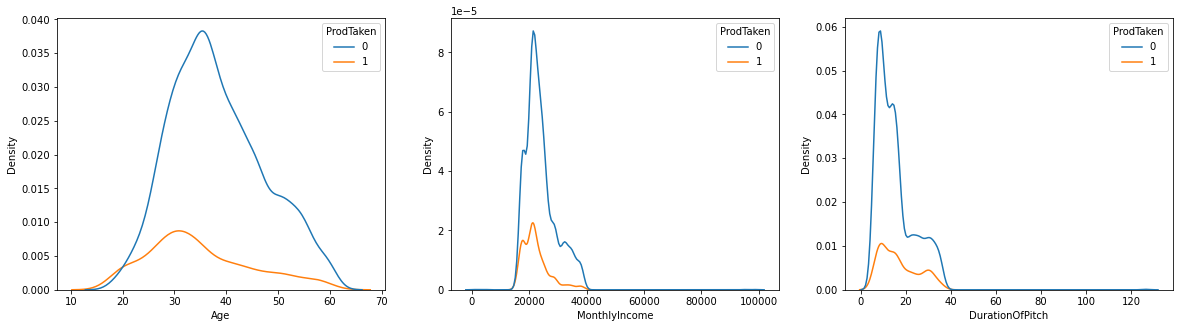

In [19]:
fig, axes = plt.subplots(1,3, figsize=(20,5))
for i,col in enumerate(['Age', 'MonthlyIncome', 'DurationOfPitch']):
    sns.kdeplot(data[col], ax=axes[i], hue=data['ProdTaken'])
    #plt.show()

In [20]:
data.loc[:,['Age', 'MonthlyIncome', 'DurationOfPitch', 'ProdTaken']].groupby('ProdTaken').mean()

,Age,MonthlyIncome,DurationOfPitch
ProdTaken,,,
0,38.282092,23960.962835,15.169325
1,34.770548,22172.827703,16.873143


In [21]:
data.loc[:,['Age', 'MonthlyIncome', 'DurationOfPitch', 'ProdTaken']].groupby('ProdTaken').median()

,Age,MonthlyIncome,DurationOfPitch
ProdTaken,,,
0,37.0,22729.0,13.0
1,33.0,21172.0,15.0


<font color=blue>
Based on Mean and Medians:
<li> Customers who take the package have lower age
<li> Monthly Income is slightly lower for those who take product
<li> Customers who bought the product were exposed to longer duration pitches

<font color=blue>
<h3>Visualisations - Categorical

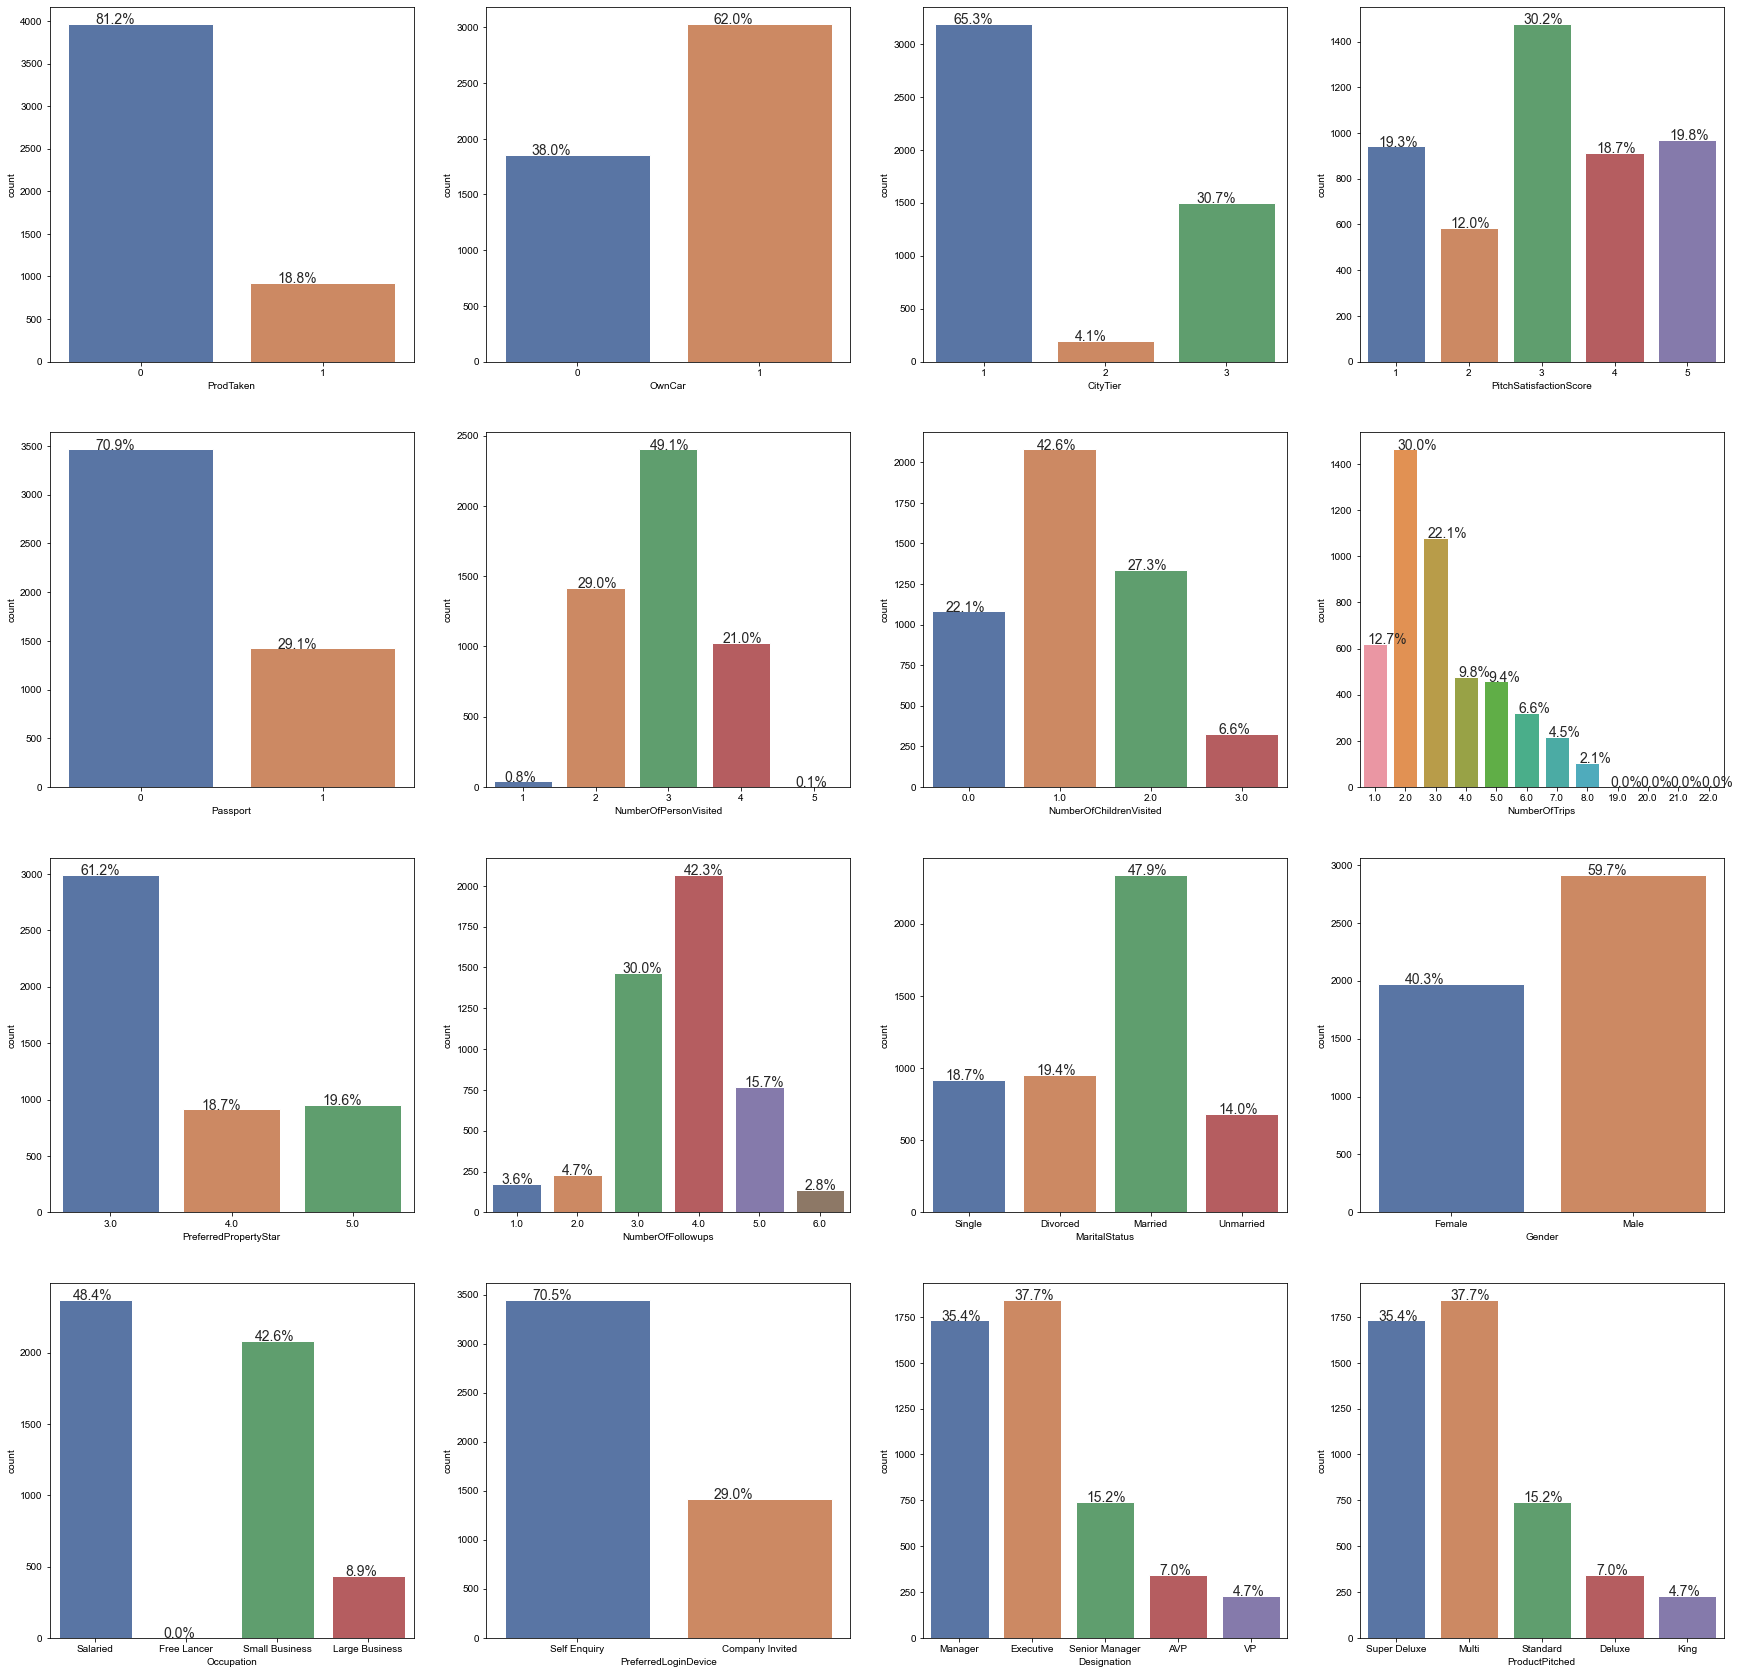

In [22]:
fig, axes = plt.subplots(4,4, figsize=(30,30))
i,j=0,0
for column in list(summary_cols[summary_cols.probably_categorical==True].index):
    #print(j,i)
    perc_on_bar(data[column], data, axes= axes[j,i], figsize=[30,30])
    i+=1
    if i==4:
        j+=1
        i=0
    

In [23]:
for column in list(summary_cols[summary_cols.probably_categorical==True].index):
    print(data[column].value_counts(normalize=True))
    print(' ')

0    0.811784
1    0.188216
Name: ProdTaken, dtype: float64
 
1    0.620295
0    0.379705
Name: OwnCar, dtype: float64
 
1    0.652619
3    0.306874
2    0.040507
Name: CityTier, dtype: float64
 
3    0.302373
5    0.198445
1    0.192717
4    0.186579
2    0.119885
Name: PitchSatisfactionScore, dtype: float64
 
0    0.709083
1    0.290917
Name: Passport, dtype: float64
 
3    0.491408
2    0.290098
4    0.209902
1    0.007979
5    0.000614
Name: NumberOfPersonVisited, dtype: float64
 
1.0    0.431356
2.0    0.276856
0.0    0.224388
3.0    0.067399
Name: NumberOfChildrenVisited, dtype: float64
 
2.0     0.308340
3.0     0.227254
1.0     0.130581
4.0     0.100674
5.0     0.096462
6.0     0.067818
7.0     0.045914
8.0     0.022115
20.0    0.000211
19.0    0.000211
22.0    0.000211
21.0    0.000211
Name: NumberOfTrips, dtype: float64
 
3.0    0.615590
5.0    0.196627
4.0    0.187783
Name: PreferredPropertyStar, dtype: float64
 
4.0    0.427008
3.0    0.302705
5.0    0.158579
2.0    0.04728

<font color=blue>
<h3>Visualisation - Categorical, Bivariate

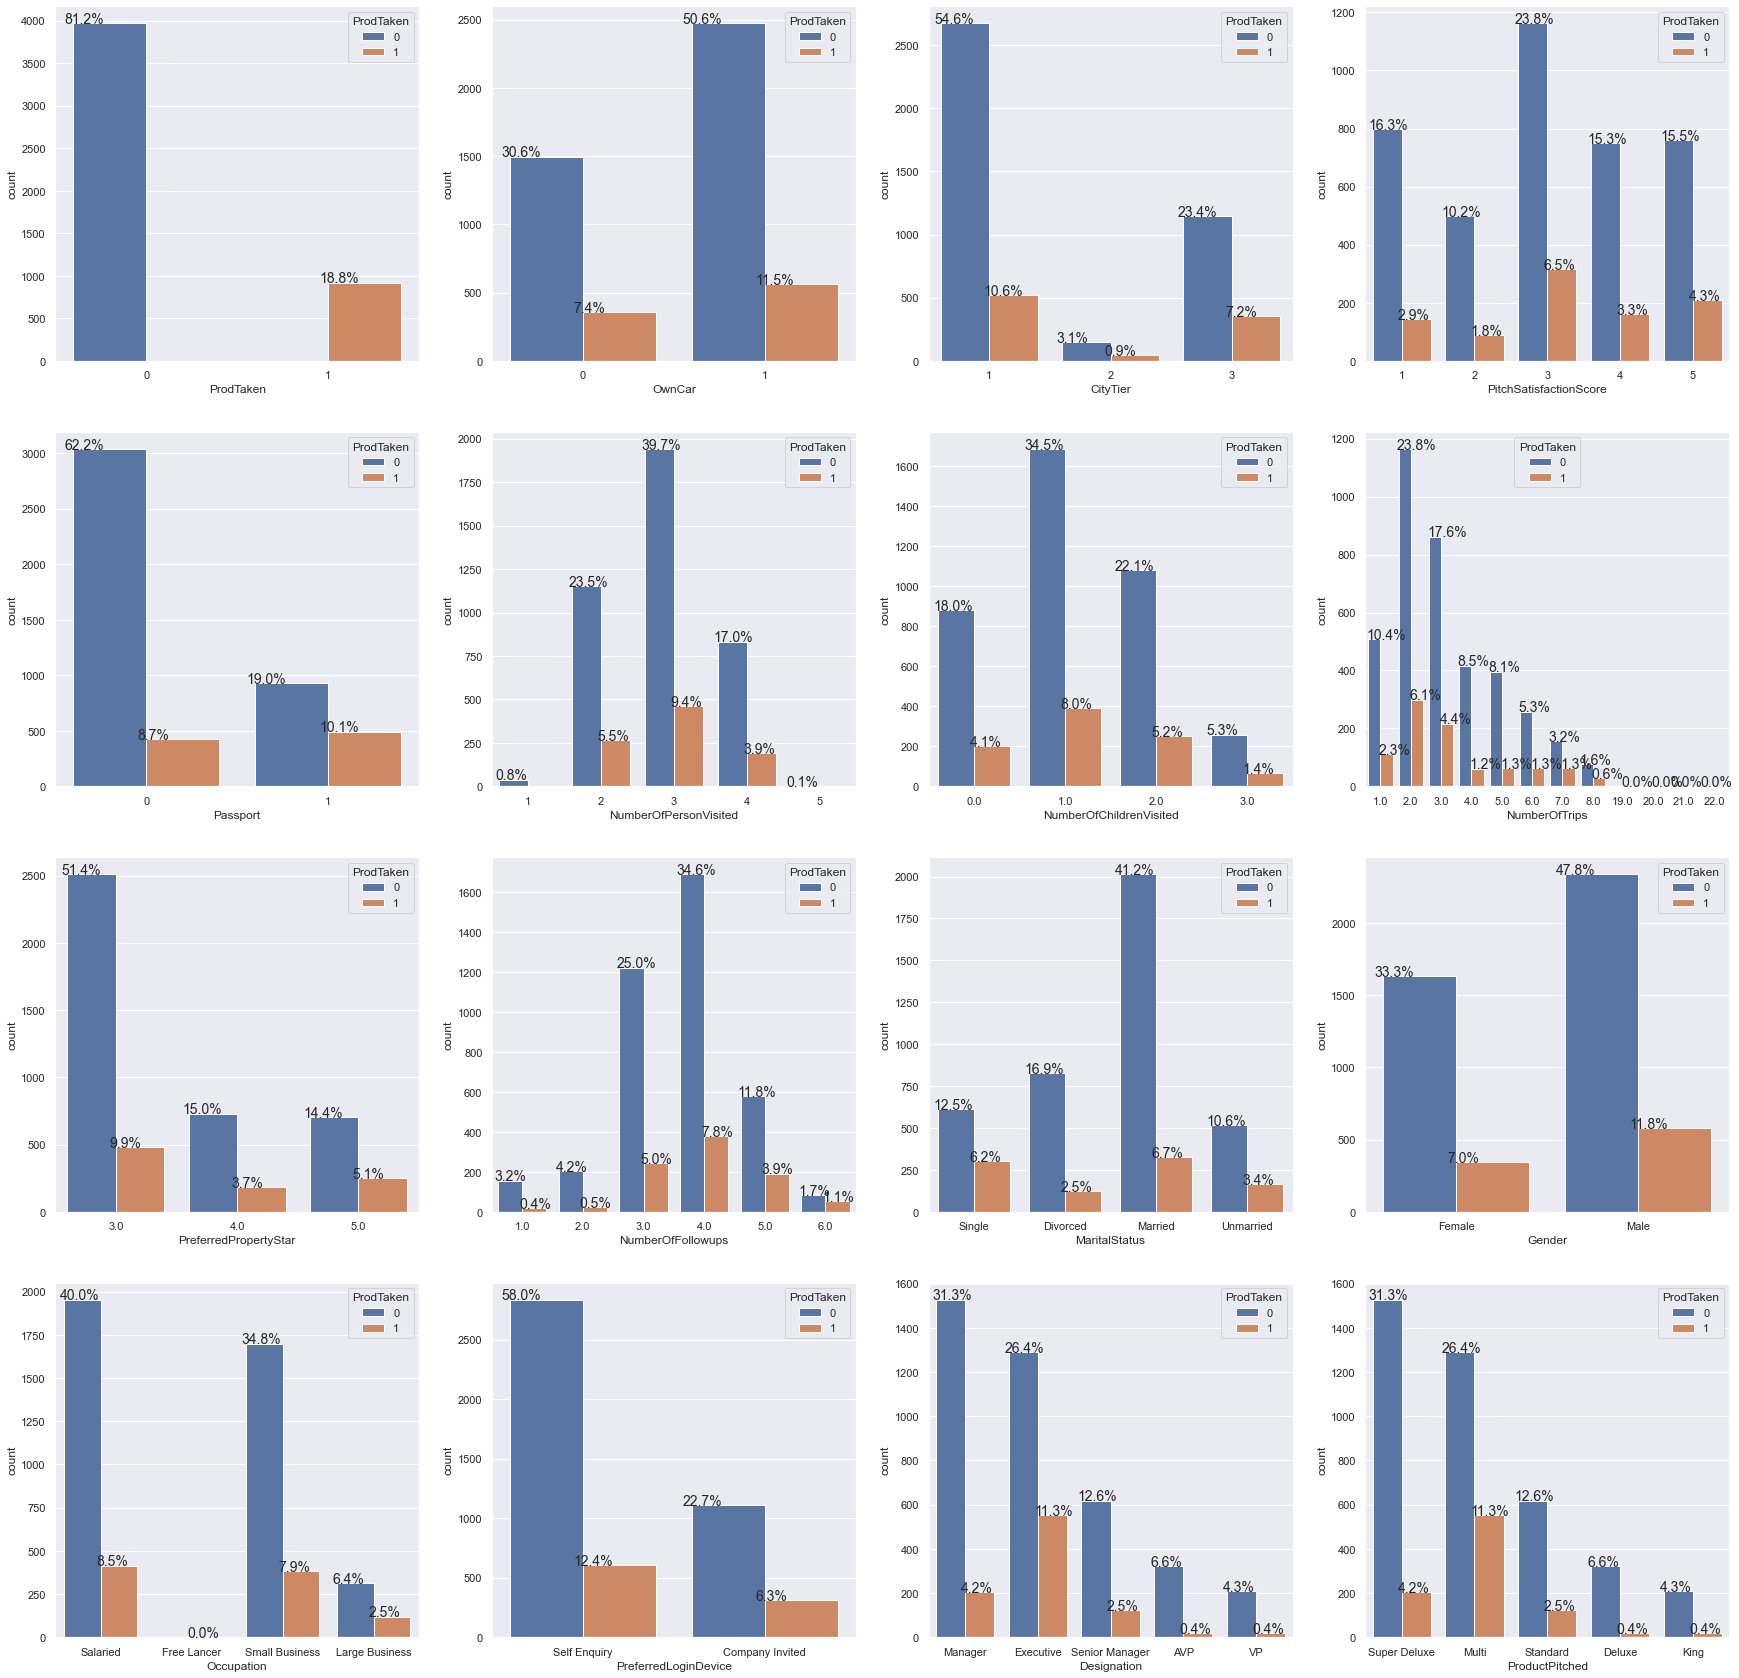

In [24]:
fig, axes = plt.subplots(4,4, figsize=(30,30))
i,j=0,0
for column in list(summary_cols[summary_cols.probably_categorical==True].index):
    #print(j,i)
    perc_on_bar(data[column], data, axes= axes[j,i], figsize=[30,30], hue='ProdTaken')
    i+=1
    if i==4:
        j+=1
        i=0

In [25]:
data.groupby('ProdTaken').mean()

,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
ProdTaken,,,,,,,,,,,,
0,38.282092,1.615927,15.169325,2.901714,3.654286,3.542806,3.219531,0.233871,3.044355,0.622984,1.184190,23960.962835
1,34.770548,1.819565,16.873143,2.919565,3.941886,3.746171,3.308370,0.536957,3.223913,0.608696,1.200438,22172.827703


In [26]:
for column in list(summary_cols[summary_cols.probably_categorical==True].index):
    display(pd.crosstab(data.ProdTaken,data[column], normalize='columns',margins=True))

ProdTaken,0,1,All
ProdTaken,,,
0,1.0,0.0,0.811784
1,0.0,1.0,0.188216


OwnCar,0,1,All
ProdTaken,,,
0,0.806034,0.815303,0.811784
1,0.193966,0.184697,0.188216


CityTier,1,2,3,All
ProdTaken,,,,
0,0.836991,0.767677,0.764,0.811784
1,0.163009,0.232323,0.236,0.188216


PitchSatisfactionScore,1,2,3,4,5,All
ProdTaken,,,,,,
0,0.847134,0.849829,0.786198,0.822368,0.783505,0.811784
1,0.152866,0.150171,0.213802,0.177632,0.216495,0.188216


Passport,0,1,All
ProdTaken,,,
0,0.877092,0.652602,0.811784
1,0.122908,0.347398,0.188216


NumberOfPersonVisited,1,2,3,4,5,All
ProdTaken,,,,,,
0,1.0,0.811707,0.808493,0.811891,1.0,0.811784
1,0.0,0.188293,0.191507,0.188109,0.0,0.188216


NumberOfChildrenVisited,0.0,1.0,2.0,3.0,All
ProdTaken,,,,,
0,0.813309,0.811538,0.810487,0.796923,0.810659
1,0.186691,0.188462,0.189513,0.203077,0.189341


NumberOfTrips,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,19.0,20.0,21.0,22.0,All
ProdTaken,,,,,,,,,,,,,
0,0.819355,0.795765,0.798888,0.872385,0.864629,0.801242,0.715596,0.72381,0.0,0.0,1.0,1.0,0.808762
1,0.180645,0.204235,0.201112,0.127615,0.135371,0.198758,0.284404,0.27619,1.0,1.0,0.0,0.0,0.191238


PreferredPropertyStar,3.0,4.0,5.0,All
ProdTaken,,,,
0,0.838958,0.800657,0.738494,0.812012
1,0.161042,0.199343,0.261506,0.187988


NumberOfFollowups,1.0,2.0,3.0,4.0,5.0,6.0,All
ProdTaken,,,,,,,
0,0.886364,0.895197,0.833561,0.816731,0.751302,0.602941,0.811687
1,0.113636,0.104803,0.166439,0.183269,0.248698,0.397059,0.188313


MaritalStatus,Divorced,Married,Single,Unmarried,All
ProdTaken,,,,,
0,0.869474,0.860684,0.668122,0.756598,0.811784
1,0.130526,0.139316,0.331878,0.243402,0.188216


Gender,Female,Male,All
ProdTaken,,,
0,0.826572,0.801783,0.811784
1,0.173428,0.198217,0.188216


Occupation,Free Lancer,Large Business,Salaried,Small Business,All
ProdTaken,,,,,
0,0.0,0.723502,0.825169,0.815739,0.811784
1,1.0,0.276498,0.174831,0.184261,0.188216


PreferredLoginDevice,Company Invited,Self Enquiry,All
ProdTaken,,,
0,0.781536,0.823751,0.811433
1,0.218464,0.176249,0.188567


Designation,AVP,Executive,Manager,Senior Manager,VP,All
ProdTaken,,,,,,
0,0.94152,0.700326,0.882217,0.832884,0.913043,0.811784
1,0.05848,0.299674,0.117783,0.167116,0.086957,0.188216


ProductPitched,Deluxe,King,Multi,Standard,Super Deluxe,All
ProdTaken,,,,,,
0,0.94152,0.913043,0.700326,0.832884,0.882217,0.811784
1,0.05848,0.086957,0.299674,0.167116,0.117783,0.188216


<font color=blue>
<li> 18.8% of the dataset is positive for the target variable (i.e. bought the product)
<li> Marginaly more men than women take packages (~20%, vs 17.5%)
<li> Designation = Executive has strong +ve impact on prod taken
<li> Divorced people unlikely to take package, single and married more likely 
<li> Multi package seems very popular (at least assuming product pitched = product bought) - almost 3 times as popular as next package which is super deluxe
<li> City Tier 2 and 3 have higher proportion of customers taking product 
<li> Higher pitch satisfacton score has a positive association with the customer taking the product
<li> Preferred property star for higher stars has higher likelihood of succesful product sale
<li> Number of followups - more followups means more likelihood of taking product
<li> Large Business occupation has more likelihood of taking product
<li> Company invited customers are more likely to take the product
<li> Executives most likely to take product followed by Senior Managers and Managers


<font color=blue>
<h3> Customer Profile vs. Product Pitched

In [27]:
data_prod = data[data.ProdTaken==1].groupby('ProductPitched') #We filter for those who actually took the product

x= data_prod.mean()
x

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
ProductPitched,,,,,,,,,,,,,
Deluxe,1.0,43.500000,2.600000,18.500000,2.700000,3.100000,3.600000,3.263158,0.600000,3.800000,1.000000,1.200000,29823.800000
King,1.0,48.900000,1.800000,10.500000,2.900000,4.300000,3.750000,3.411765,0.600000,3.300000,0.900000,1.437500,34672.100000
Multi,1.0,31.289320,1.510870,15.791353,2.905797,3.950730,3.771739,3.226691,0.583333,3.213768,0.572464,1.221416,20161.529301
Standard,1.0,41.008130,2.096774,19.065041,2.967742,3.935484,3.731707,3.016260,0.387097,3.467742,0.661290,1.121951,26035.419355
Super Deluxe,1.0,37.641414,2.411765,19.100000,2.950980,3.970000,3.699507,3.702970,0.490196,3.039216,0.607843,1.172414,23106.215385


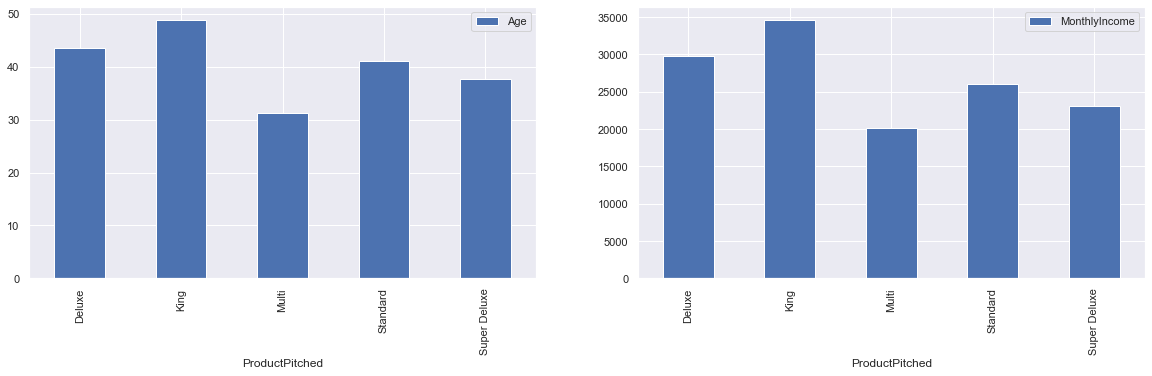

In [28]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
x['Age'].plot(kind='bar', ax=axes[0], legend=True)
x['MonthlyIncome'].plot(kind='bar', ax=axes[1], legend=True)
del(x)

In [29]:
columns = ['PreferredLoginDevice', 'CityTier', 'Occupation', 'Gender', 'NumberOfPersonVisited', 'PreferredPropertyStar', 'MaritalStatus','NumberOfTrips','Passport','OwnCar','NumberOfChildrenVisited','Designation']

df_prod1 = data[data.ProdTaken==1]

for col in columns:
    display(pd.crosstab(df_prod1['ProductPitched'], df_prod1[col], normalize='index'))

PreferredLoginDevice,Company Invited,Self Enquiry
ProductPitched,,
Deluxe,0.800000,0.200000
King,0.000000,1.000000
Multi,0.353370,0.646630
Standard,0.258065,0.741935
Super Deluxe,0.333333,0.666667


CityTier,1,2,3
ProductPitched,,,
Deluxe,0.200000,0.000000,0.800000
King,0.600000,0.000000,0.400000
Multi,0.710145,0.068841,0.221014
Standard,0.419355,0.064516,0.516129
Super Deluxe,0.294118,0.000000,0.705882


Occupation,Free Lancer,Large Business,Salaried,Small Business
ProductPitched,,,,
Deluxe,0.000000,0.000000,0.800000,0.200000
King,0.000000,0.200000,0.200000,0.600000
Multi,0.003623,0.159420,0.471014,0.365942
Standard,0.000000,0.096774,0.435484,0.467742
Super Deluxe,0.000000,0.078431,0.392157,0.529412


Gender,Female,Male
ProductPitched,,
Deluxe,0.200000,0.800000
King,0.600000,0.400000
Multi,0.376812,0.623188
Standard,0.387097,0.612903
Super Deluxe,0.343137,0.656863


NumberOfPersonVisited,2,3,4
ProductPitched,,,
Deluxe,0.400000,0.5,0.100000
King,0.300000,0.5,0.200000
Multi,0.297101,0.5,0.202899
Standard,0.266129,0.5,0.233871
Super Deluxe,0.274510,0.5,0.225490


PreferredPropertyStar,3.0,4.0,5.0
ProductPitched,,,
Deluxe,0.600000,0.200000,0.200000
King,0.375000,0.500000,0.125000
Multi,0.510870,0.206522,0.282609
Standard,0.552846,0.162602,0.284553
Super Deluxe,0.561576,0.177340,0.261084


MaritalStatus,Divorced,Married,Single,Unmarried
ProductPitched,,,,
Deluxe,0.000000,0.400000,0.500000,0.100000
King,0.300000,0.300000,0.400000,0.000000
Multi,0.108696,0.340580,0.416667,0.134058
Standard,0.209677,0.451613,0.088710,0.250000
Super Deluxe,0.156863,0.333333,0.220588,0.289216


NumberOfTrips,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,19.0,20.0
ProductPitched,,,,,,,,,,
Deluxe,0.315789,0.315789,0.000000,0.000000,0.105263,0.105263,0.105263,0.052632,0.000000,0.000000
King,0.117647,0.235294,0.352941,0.058824,0.000000,0.117647,0.117647,0.000000,0.000000,0.000000
Multi,0.102377,0.361974,0.283364,0.049360,0.047532,0.053016,0.063985,0.034735,0.001828,0.001828
Standard,0.162602,0.341463,0.235772,0.081301,0.040650,0.056911,0.056911,0.024390,0.000000,0.000000
Super Deluxe,0.138614,0.242574,0.133663,0.113861,0.143564,0.118812,0.079208,0.029703,0.000000,0.000000


Passport,0,1
ProductPitched,,
Deluxe,0.400000,0.600000
King,0.400000,0.600000
Multi,0.416667,0.583333
Standard,0.612903,0.387097
Super Deluxe,0.509804,0.490196


OwnCar,0,1
ProductPitched,,
Deluxe,0.000000,1.000000
King,0.100000,0.900000
Multi,0.427536,0.572464
Standard,0.338710,0.661290
Super Deluxe,0.392157,0.607843


NumberOfChildrenVisited,0.0,1.0,2.0,3.0
ProductPitched,,,,
Deluxe,0.200000,0.450000,0.300000,0.050000
King,0.125000,0.437500,0.312500,0.125000
Multi,0.214156,0.424682,0.286751,0.074410
Standard,0.268293,0.422764,0.227642,0.081301
Super Deluxe,0.221675,0.443350,0.275862,0.059113


Designation,AVP,Executive,Manager,Senior Manager,VP
ProductPitched,,,,,
Deluxe,1.0,0.0,0.0,0.0,0.0
King,0.0,0.0,0.0,0.0,1.0
Multi,0.0,1.0,0.0,0.0,0.0
Standard,0.0,0.0,0.0,1.0,0.0
Super Deluxe,0.0,0.0,1.0,0.0,0.0


<font color=blue>
Summary profile of customer by type of product taken (filtering for product pitched and prodtaken==1 assuming that product taken is product pitched)
<img src='profile.jpg' height = '75%' width='75%'></img>

<font color=darkblue>
<h4>Customer profiles by pitched product</h4>
<table>
<tr height=68 style='height:51.0pt'>
  <td height=68 class=xl63 width=87 style='height:51.0pt;width:65pt'>Product
  Type</td>
  <td class=xl63 width=87 style='width:65pt'>Mean Age</td>
  <td class=xl63 width=87 style='width:65pt'>Mean Monthly Income</td>
  <td class=xl63 width=164 style='width:123pt'>Preferred Login</td>
  <td class=xl63 width=87 style='width:65pt'>City Tier</td>
  <td class=xl63 width=119 style='width:89pt'>Occupation</td>
  <td class=xl63 width=87 style='width:65pt'>Gender</td>
  <td class=xl63 width=87 style='width:65pt'>No of Person Visited</td>
  <td class=xl63 width=87 style='width:65pt'>Pref Prop Star</td>
  <td class=xl63 width=111 style='width:83pt'>Marital Status</td>
  <td class=xl63 width=87 style='width:65pt'>No of Trips</td>
  <td class=xl63 width=87 style='width:65pt'>Passport</td>
  <td class=xl63 width=87 style='width:65pt'>Own Car</td>
  <td class=xl63 width=87 style='width:65pt'>No of Children</td>
  <td class=xl63 width=87 style='width:65pt'>Desig</td>
 </tr>
 <tr height=45 style='height:34.0pt'>
  <td height=45 style='height:34.0pt'>Multi</td>
  <td align=right>31.3</td>
  <td align=right>20162</td>
  <td>Self Enquiry (65%)</td>
  <td>1-71%</td>
  <td class=xl64 width=119 style='width:89pt'>Salaried-47%, Small Bus 37%</td>
  <td>Male 62%</td>
  <td class=xl65 width=87 style='width:65pt'>3-50%, 2-30%</td>
  <td class=xl64 width=87 style='width:65pt'>3-51%, 5-28%</td>
  <td class=xl64 width=111 style='width:83pt'>Single-42%, Married-34%</td>
  <td class=xl64 width=87 style='width:65pt'>2-36%, 3-28%</td>
  <td class=xl64 width=87 style='width:65pt'>1-58%</td>
  <td class=xl64 width=87 style='width:65pt'>1-57%</td>
  <td class=xl64 width=87 style='width:65pt'>1-42%, 2-29%</td>
  <td class=xl64 width=87 style='width:65pt'>Executive-100%</td>
 </tr>
 <tr height=45 style='height:34.0pt'>
  <td height=45 style='height:34.0pt'>Deluxe</td>
  <td align=right>43.5</td>
  <td align=right>29824</td>
  <td>Company Invited (80%)</td>
  <td>3-80%</td>
  <td class=xl64 width=119 style='width:89pt'>Salaried-80%</td>
  <td>Male 80%</td>
  <td class=xl65 width=87 style='width:65pt'>3-50%, 2-40%</td>
  <td class=xl64 width=87 style='width:65pt'>3-60%, 4,5-20%</td>
  <td class=xl64 width=111 style='width:83pt'>Single-50%, Married-40%</td>
  <td class=xl64 width=87 style='width:65pt'>1,2-32%</td>
  <td class=xl64 width=87 style='width:65pt'>1-60%</td>
  <td class=xl64 width=87 style='width:65pt'>1-100%</td>
  <td class=xl64 width=87 style='width:65pt'>1-45%, 2-30%</td>
  <td class=xl64 width=87 style='width:65pt'>AVP-100%</td>
 </tr>
 <tr height=68 style='height:51.0pt'>
  <td height=68 style='height:51.0pt'>King</td>
  <td align=right>48.9</td>
  <td align=right>34672</td>
  <td>Self Enquiry (100%)</td>
  <td>1-60%</td>
  <td class=xl64 width=119 style='width:89pt'>Small Bus 60%</td>
  <td>Female 60%</td>
  <td class=xl65 width=87 style='width:65pt'>3-50%, 2-30%</td>
  <td class=xl64 width=87 style='width:65pt'>4-50%,3-37.5%</td>
  <td class=xl64 width=111 style='width:83pt'>Single-40%, Married, Divorced-30%</td>
  <td class=xl64 width=87 style='width:65pt'>3-35%, 2-24%</td>
  <td class=xl64 width=87 style='width:65pt'>1-60%</td>
  <td class=xl64 width=87 style='width:65pt'>1-90%</td>
  <td class=xl64 width=87 style='width:65pt'>1-44%, 2-31%</td>
  <td class=xl64 width=87 style='width:65pt'>VP-100%</td>
 </tr>
 <tr height=68 style='height:51.0pt'>
  <td height=68 style='height:51.0pt'>Standard</td>
  <td align=right>41</td>
  <td align=right>26035</td>
  <td>Self Enquiry (74%)</td>
  <td>3-51%</td>
  <td class=xl64 width=119 style='width:89pt'>Small Bus 47%, Salaried 44%</td>
  <td>Male 61%</td>
  <td class=xl65 width=87 style='width:65pt'>3-50%, 2-27%</td>
  <td class=xl64 width=87 style='width:65pt'>3-55%, 5-28%</td>
  <td class=xl64 width=111 style='width:83pt'>Married-45%, Unmarried-25%</td>
  <td class=xl64 width=87 style='width:65pt'>2-34%, 3-24%</td>
  <td class=xl64 width=87 style='width:65pt'>0-61%</td>
  <td class=xl64 width=87 style='width:65pt'>1-66%</td>
  <td class=xl64 width=87 style='width:65pt'>1-42%, 0-27%</td>
  <td class=xl64 width=87 style='width:65pt'>Senior Manager-100%</td>
 </tr>
 <tr height=68 style='height:51.0pt'>
  <td height=68 style='height:51.0pt'>Super Deluxe</td>
  <td align=right>37.6</td>
  <td align=right>23106</td>
  <td>Self Enquiry (67%)</td>
  <td>3-71%</td>
  <td class=xl64 width=119 style='width:89pt'>Small Bus 53%, Salaried 39%</td>
  <td>Male 66%</td>
  <td class=xl65 width=87 style='width:65pt'>3-50%, 2-27%</td>
  <td class=xl64 width=87 style='width:65pt'>3-56%, 5-26%</td>
  <td class=xl64 width=111 style='width:83pt'>Married-33%, Unmarried-29%</td>
  <td class=xl64 width=87 style='width:65pt'>2-24%</td>
  <td class=xl64 width=87 style='width:65pt'>0-51%</td>
  <td class=xl64 width=87 style='width:65pt'>1-61%</td>
  <td class=xl64 width=87 style='width:65pt'>1-44%, 2-28%</td>
  <td class=xl64 width=87 style='width:65pt'>Manager-100%</td>
 </tr>
</table>

<font color=blue>
<li>Multi users  are Executives, and mostly: single or married (76%), have passport flag 1 (58%), from city tier 1 (71%), male (62%), chose self enquiry (65%) with mean age and income of 31 and 20162</li>
<li> others we can see from table above - note that product type and designation are in 1-1 correspondence - will discuss and treat as below</li>


<font color=Blue>
<h2> Filling NaNs/ Other Analysis


In [30]:
data.groupby(['ProductPitched','Designation']).count()

,,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
ProductPitched,Designation,,,,,,,,,,,,,,,,,
Deluxe,AVP,342,342,342,342,342,342,342,342,342,342,342,292,342,342,342,300,342
King,VP,230,230,230,230,230,230,230,230,230,207,230,148,230,230,230,209,230
Multi,Executive,1842,1698,1832,1842,1781,1842,1842,1842,1829,1841,1842,1837,1842,1842,1842,1841,1755
Standard,Senior Manager,742,741,742,742,741,742,742,742,742,741,742,741,742,742,742,741,742
Super Deluxe,Manager,1732,1651,1717,1732,1543,1732,1732,1732,1700,1731,1732,1730,1732,1732,1732,1731,1586


<font color=blue>
<li> Note: Since Designation is exactly the same pattern as Product Type we can drop one of the columns

In [31]:
# Copy to avoid corrupting original df in case need to undo changes
working_df = data.copy()

<font color=blue>
<h3> Children NaNs


In [32]:
#no meaningful relation if we bin age
working_df['AgeBins'] = pd.cut(working_df.Age, bins=5, labels=range(0,5))
working_df.groupby('AgeBins').mean()['NumberOfChildrenVisited']

AgeBins
0    1.169978
1    1.197166
2    1.252882
3    1.245817
4    1.140162
Name: NumberOfChildrenVisited, dtype: float64

In [33]:
#Filling nans in Children - using mode as modal value is same across all marital status and mean is also ~1 across marital categories (no of children =1)
import math

display(working_df.groupby('MaritalStatus').mean()['NumberOfChildrenVisited'])

temp_df = working_df.copy()
# using 1000 as a placeholder value for NaN since crosstab ignores NaN
temp_df.NumberOfChildrenVisited = temp_df.NumberOfChildrenVisited.apply(lambda x: 1000 if math.isnan(x) else x)
display(pd.crosstab(temp_df.MaritalStatus, temp_df.NumberOfChildrenVisited, margins=True))
del(temp_df)



working_df.NumberOfChildrenVisited = working_df.NumberOfChildrenVisited.apply(lambda x: 1 if math.isnan(x) else x)

pd.crosstab(working_df.MaritalStatus, working_df.NumberOfChildrenVisited, margins=True)


MaritalStatus
Divorced     1.157556
Married      1.212462
Single       0.997768
Unmarried    1.391496
Name: NumberOfChildrenVisited, dtype: float64

NumberOfChildrenVisited,0.0,1.0,2.0,3.0,1000.0,All
MaritalStatus,,,,,,
Divorced,226,400,241,66,17,950
Married,498,987,663,163,29,2340
Single,276,383,200,37,20,916
Unmarried,82,310,231,59,0,682
All,1082,2080,1335,325,66,4888


NumberOfChildrenVisited,0.0,1.0,2.0,3.0,All
MaritalStatus,,,,,
Divorced,226,417,241,66,950
Married,498,1016,663,163,2340
Single,276,403,200,37,916
Unmarried,82,310,231,59,682
All,1082,2146,1335,325,4888


<font color=Blue>
<li> The means for children Visited across diff marital categories and across age bins is close to 1, the modal value for children is also 1 both across the whole data and within each marital category
<li> So I just set nan in children to 1
<li>Number of Children visited is correlated with Number of Persons but the modal value is so significant I use 1 to fill nan

<font color=blue>
<h3>Number of Trips NaNs & outliers

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
NumberOfTrips,,,,,,,,,,,,
1.0,0.180645,37.947368,1.693548,14.370968,2.401613,3.181818,3.609047,0.267742,3.166129,0.625806,0.685484,22048.389680
2.0,0.204235,34.800727,1.680328,15.507236,2.814208,3.614698,3.570548,0.284153,3.066940,0.635246,1.081284,22365.698901
3.0,0.201112,34.782732,1.653383,16.067943,3.177943,4.003749,3.574488,0.297498,3.009268,0.621872,1.452271,23432.665720
4.0,0.127615,42.002151,1.629707,15.909292,2.830544,3.671548,3.568134,0.320084,3.098326,0.564854,1.112971,24576.316703
5.0,0.135371,41.579065,1.615721,16.041667,2.903930,3.665929,3.516630,0.325328,3.161572,0.593886,1.183406,24086.855856
6.0,0.198758,40.954839,1.673913,15.987013,3.071429,3.822981,3.615142,0.288820,2.990683,0.627329,1.369565,24205.265574
7.0,0.284404,38.918660,1.642202,14.786730,2.935780,3.789720,3.699074,0.256881,3.022936,0.619266,1.201835,23562.361502
8.0,0.276190,39.057143,1.533333,13.904762,3.495238,4.323810,3.653846,0.266667,3.257143,0.609524,1.771429,24621.704762
19.0,1.000000,30.000000,1.000000,10.000000,2.000000,3.000000,3.000000,1.000000,4.000000,1.000000,1.000000,17285.000000


,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins
NumberOfTrips,,,,,,,,,,,,,,,,,,,
1.0,620,551,614,620,558,620,620,620,605,620,619,620,620,620,620,620,620,562,551
2.0,1464,1375,1456,1464,1382,1464,1464,1464,1456,1464,1460,1464,1464,1464,1464,1464,1464,1365,1375
3.0,1079,1054,1076,1079,1045,1079,1079,1079,1067,1079,1074,1079,1079,1079,1079,1079,1079,1056,1054
4.0,478,465,475,478,452,478,478,478,478,478,477,478,478,478,478,478,478,461,465
5.0,458,449,456,458,432,458,458,458,452,458,451,458,458,458,458,458,458,444,449
6.0,322,310,321,322,308,322,322,322,322,322,317,322,322,322,322,322,322,305,310
7.0,218,209,216,218,211,218,218,218,214,218,216,218,218,218,218,218,218,213,209
8.0,105,105,105,105,105,105,105,105,105,105,104,105,105,105,105,105,105,105,105
19.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


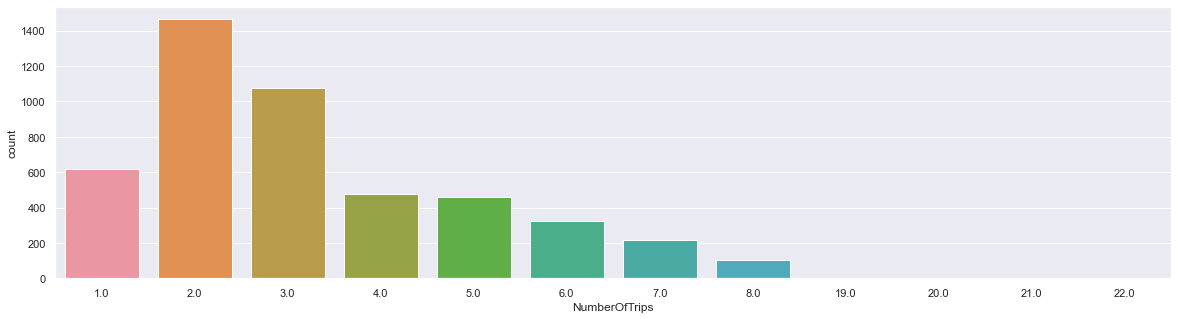

In [34]:
#Fixing outliers and nan in NumberOfTrips
plt.figure(figsize=(20,5))
sns.countplot(working_df['NumberOfTrips'])
display(working_df.groupby('NumberOfTrips').mean())
display(working_df.groupby('NumberOfTrips').count())
#display(working_df[working_df.NumberOfTrips.isna()])



In [35]:
print('mean', working_df.NumberOfTrips.mean(), 'median', working_df.NumberOfTrips.median())

mean 3.236520640269587 median 3.0


In [36]:
temp_df = working_df[working_df.NumberOfTrips <=8]
print('mean where trips <=8:', temp_df.NumberOfTrips.mean(), 'median', temp_df.NumberOfTrips.median())

mean where trips <=8: 3.221964586846543 median 3.0


In [37]:
#No significant correlation with NumberOfTrips and any other var so we impute nan to median
#prefer median to mode as mode is 2 and NumberofTrips=3 is also significantly represented. Could also use mean but prefer using int values 
#mean=3.2 which is not strictly speaking possible although still possible to use for imputation to enable model fitting


from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

#using only 

x=imp_median.fit_transform(working_df[['NumberOfTrips']])
s=pd.Series(x.flatten(),index=working_df.index)
s
working_df['NumberOfTrips'] = s

working_df

,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Super Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0,2
1,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Super Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0,3
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Multi,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0,2
3,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Multi,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0,1
4,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Multi,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,1,49.0,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Super Deluxe,4.0,Unmarried,2.0,1,1,1,1.0,Manager,26576.0,3
4884,1,28.0,Company Invited,1,31.0,Salaried,Male,4,5.0,Multi,3.0,Single,3.0,1,3,1,2.0,Executive,21212.0,1
4885,1,52.0,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,Senior Manager,31820.0,3
4886,1,19.0,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Multi,3.0,Single,3.0,0,5,0,2.0,Executive,20289.0,0


In [38]:
#working_df['NumberOfTripsOutlier'] = working_df['NumberOfTrips'].apply(lambda x: 1 if x > 8 else 0)
working_df[working_df['NumberOfTrips']>8].shape[0]

4

<font color = 'blue'>
<li> Only 4 rows have outliers but tree based models are robust to outliers so we dont drop them
<li> Additionally, use median = 3 to replace NaN since median is same with or without outliers and mean is close to median ~3.22 but prefer to use int values for a discrete variable

<font color=blue>
<h3>Pref Prop Star NaNs

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
PreferredPropertyStar,,,,,,,,,,,,
3.0,0.161042,37.670403,1.655864,15.527709,2.884063,3.718908,3.203809,0.295356,3.085533,0.612429,1.157033,23521.668765
4.0,0.199343,37.174857,1.685652,15.536782,2.914567,3.708749,3.258488,0.260679,3.141292,0.628697,1.212486,23227.312285
5.0,0.261506,37.533113,1.623431,15.363436,2.945607,3.652587,3.251046,0.306485,2.981172,0.629707,1.225941,23819.335929


,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins
PreferredPropertyStar,,,,,,,,,,,,,,,,,,,
3.0,2993,2855,2974,2993,2833,2993,2993,2993,2967,2993,2993,2993,2993,2993,2993,2993,2993,2859,2855
4.0,913,875,912,913,870,913,913,913,903,913,913,913,913,913,913,913,913,871,875
5.0,956,906,951,956,908,956,956,956,947,956,956,956,956,956,956,956,956,899,906


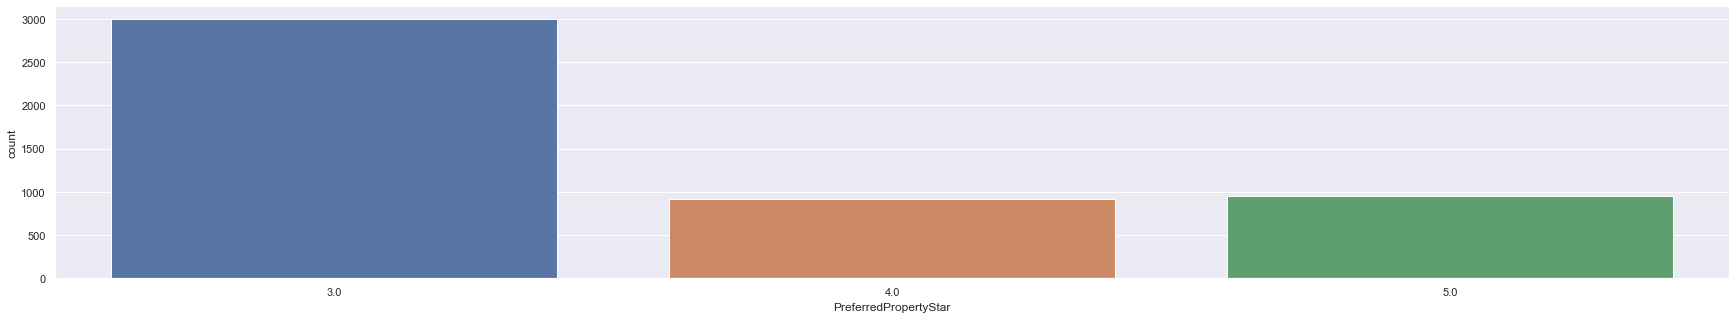

In [39]:
#Fixing nan in PreferredPropertyStar
plt.figure(figsize=(30,5))
sns.countplot(working_df['PreferredPropertyStar'])
display(working_df.groupby('PreferredPropertyStar').mean())
display(working_df.groupby('PreferredPropertyStar').count())
#display(working_df[working_df.PreferredPropertyStar.isna()])

In [40]:
print('mean', working_df.PreferredPropertyStar.mean(), 'median', working_df.PreferredPropertyStar.median())

mean 3.581036610448375 median 3.0


In [41]:
#No significant correlation with PreferredPropertyStar and any other var so we impute nan to mode

x=imp_mode.fit_transform(working_df[['PreferredPropertyStar']])
s=pd.Series(x.flatten(),index=working_df.index)
s
working_df['PreferredPropertyStar'] = s

working_df

,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Super Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0,2
1,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Super Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0,3
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Multi,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0,2
3,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Multi,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0,1
4,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Multi,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,1,49.0,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Super Deluxe,4.0,Unmarried,2.0,1,1,1,1.0,Manager,26576.0,3
4884,1,28.0,Company Invited,1,31.0,Salaried,Male,4,5.0,Multi,3.0,Single,3.0,1,3,1,2.0,Executive,21212.0,1
4885,1,52.0,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,Senior Manager,31820.0,3
4886,1,19.0,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Multi,3.0,Single,3.0,0,5,0,2.0,Executive,20289.0,0


<font color=blue>
<li> Using mode to replace NaN in PreferredPropertyStar

<font color=blue>
<h3> NaN in NumberOfFollowups

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
NumberOfFollowups,,,,,,,,,,,,
1.0,0.113636,37.381250,1.568182,15.248447,2.437500,3.630682,2.744318,0.301136,2.875000,0.613636,0.704545,21239.670732
2.0,0.104803,37.892857,1.558952,16.180180,3.205240,3.655022,3.475983,0.301310,2.930131,0.606987,1.528384,24064.915929
3.0,0.166439,37.490950,1.654843,15.220957,2.449523,3.577080,2.789905,0.286494,3.120055,0.615280,0.718963,22019.930904
4.0,0.183269,37.839126,1.661025,15.624378,3.096228,3.575919,3.403772,0.289168,3.107350,0.620406,1.368956,24342.400099
5.0,0.248698,37.371202,1.652344,15.358289,3.217448,3.572917,3.562500,0.299479,3.029948,0.631510,1.515625,24838.099338
6.0,0.397059,37.250000,1.735294,16.552239,3.389706,3.433824,3.808824,0.316176,2.904412,0.632353,1.691176,24998.036765


,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins
NumberOfFollowups,,,,,,,,,,,,,,,,,,,
1.0,176,160,172,176,161,176,176,176,176,176,176,176,176,176,176,176,176,164,160
2.0,229,224,229,229,222,229,229,229,229,229,229,229,229,229,229,229,229,226,224
3.0,1466,1326,1456,1466,1317,1466,1466,1466,1466,1466,1466,1466,1466,1466,1466,1466,1466,1317,1326
4.0,2068,2014,2061,2068,2010,2068,2068,2068,2068,2068,2068,2068,2068,2068,2068,2068,2068,2012,2014
5.0,768,757,764,768,748,768,768,768,768,768,768,768,768,768,768,768,768,755,757
6.0,136,136,136,136,134,136,136,136,136,136,136,136,136,136,136,136,136,136,136


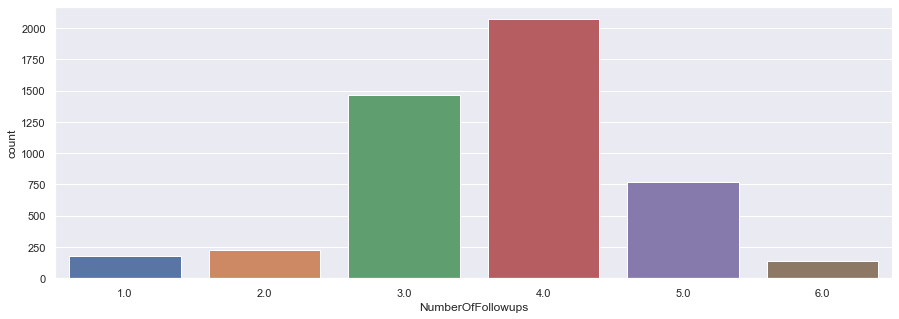

In [42]:
#Fixing nan in NumberOfFollowups
plt.figure(figsize=(15,5))
sns.countplot(working_df['NumberOfFollowups'])
display(working_df.groupby('NumberOfFollowups').mean())
display(working_df.groupby('NumberOfFollowups').count())
#display(working_df[working_df.NumberOfFollowups.isna()])

In [43]:
#No significant correlation with NumberOfFollowups and any other var so we impute nan to mode

x=imp_mode.fit_transform(working_df[['NumberOfFollowups']])
s=pd.Series(x.flatten(),index=working_df.index)
s
working_df['NumberOfFollowups'] = s

working_df

,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Super Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0,2
1,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Super Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0,3
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Multi,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0,2
3,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Multi,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0,1
4,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Multi,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,1,49.0,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Super Deluxe,4.0,Unmarried,2.0,1,1,1,1.0,Manager,26576.0,3
4884,1,28.0,Company Invited,1,31.0,Salaried,Male,4,5.0,Multi,3.0,Single,3.0,1,3,1,2.0,Executive,21212.0,1
4885,1,52.0,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,Senior Manager,31820.0,3
4886,1,19.0,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Multi,3.0,Single,3.0,0,5,0,2.0,Executive,20289.0,0


<font color = blue>
<li> Fixed NaN in NumberOfFollowups to mode

<font color=blue>
<h3>NaN in PreferredLoginDevice

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
PreferredLoginDevice,,,,,,,,,,,,,
Company Invited,0.218464,37.286344,1.668076,15.894303,2.909091,3.736434,3.539112,3.198732,0.290345,3.116984,0.618041,1.194503,23390.292068
Self Enquiry,0.176249,37.819542,1.648664,15.327884,2.907666,3.703833,3.594948,3.244774,0.293264,3.064170,0.621661,1.184959,23713.525106


,ProdTaken,Age,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins
PreferredLoginDevice,,,,,,,,,,,,,,,,,,,
Company Invited,1419,1362,1419,1334,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419,1419,1349,1362
Self Enquiry,3444,3275,3444,3303,3444,3444,3444,3444,3444,3444,3444,3444,3444,3444,3444,3444,3444,3306,3275


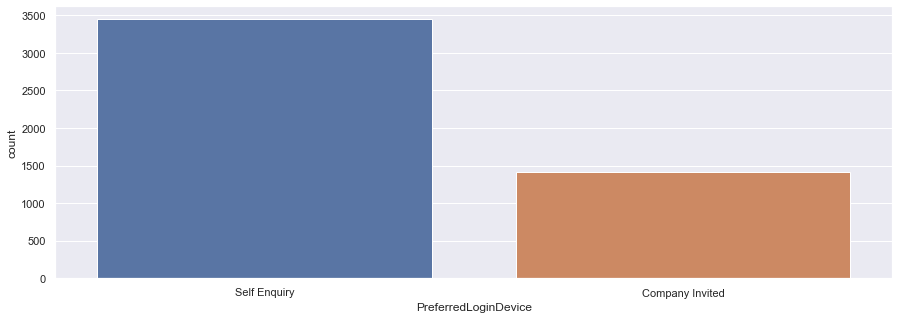

In [44]:
#Fixing nan in PreferredLoginDevice
plt.figure(figsize=(15,5))
sns.countplot(working_df['PreferredLoginDevice'])
display(working_df.groupby('PreferredLoginDevice').mean())
display(working_df.groupby('PreferredLoginDevice').count())
#display(working_df[working_df.PreferredLoginDevice.isna()])

In [45]:
#No significant correlation with PreferredLoginDevice and any other var so we impute nan to mode

x=imp_mode.fit_transform(working_df[['PreferredLoginDevice']])
s=pd.Series(x.flatten(),index=working_df.index)
s
working_df['PreferredLoginDevice'] = s

#working_df

<font color=blue>
<li> Fixed NaN in PrefLogin to mode

In [46]:
summary_cols2 = make_summary_cols(working_df)
display(summary_cols2)

,nuniques,dtypes,nulls,isnumeric_column,probably_categorical
ProdTaken,2,int64,0,True,True
OwnCar,2,int64,0,True,True
CityTier,3,int64,0,True,True
PitchSatisfactionScore,5,int64,0,True,True
Passport,2,int64,0,True,True
NumberOfPersonVisited,5,int64,0,True,True
NumberOfChildrenVisited,4,float64,0,True,True
NumberOfTrips,12,float64,0,True,True
PreferredPropertyStar,3,float64,0,True,True
MonthlyIncome,2475,float64,233,True,False


<font color=blue>
<h3> NaN in Age

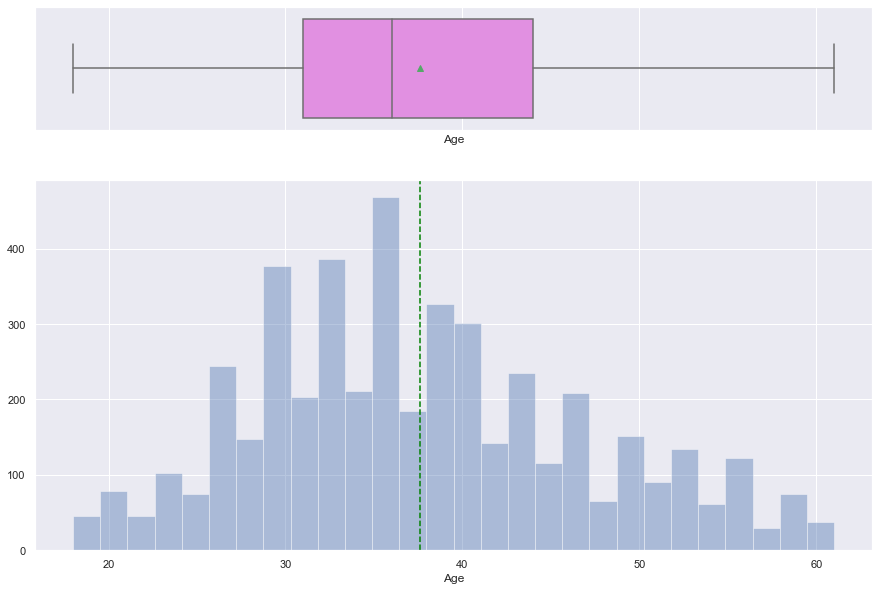

In [47]:
histogram_boxplot(working_df.Age)

In [48]:
print('mean', working_df.Age.mean(), 'median', working_df.Age.median())

mean 37.62226512226512 median 36.0


In [49]:
working_df.groupby('AgeBins').mean()

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
AgeBins,,,,,,,,,,,,,
0,0.397351,23.181015,1.728477,16.021792,2.867550,3.644592,3.578366,2.571744,0.320088,3.178808,0.567329,1.169978,19708.016018
1,0.211889,31.357858,1.687463,15.489281,2.932902,3.770453,3.589170,3.007652,0.257799,3.035315,0.604473,1.196586,21922.054579
2,0.119392,39.123954,1.628897,15.424581,2.953612,3.732319,3.577186,3.519392,0.294297,2.996958,0.630418,1.250190,24266.525869
3,0.150498,47.603234,1.671642,15.442581,2.962687,3.753731,3.555970,3.597015,0.318408,3.174129,0.645522,1.237562,26804.689394
4,0.148338,56.000000,1.639386,15.289062,2.879795,3.682864,3.557545,3.677749,0.327366,3.161125,0.659847,1.132992,27862.619171


In [50]:
working_df[working_df.Age.isna() & working_df.MonthlyIncome.isna()]
#while there is some correlation between Age and MonthlyIncome, 130 rows have both missing (out of total ~225-230 for each)
#we can see above that there is some correlation between AgeBins and NumberOfTrips but again it's very weak
#best to just use mean for age and monthlyincome

,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins
11,0,NaN,Self Enquiry,1,21.0,Salaried,Female,2,4.0,Super Deluxe,3.0,Single,1.0,1,3,0,0.0,Manager,NaN,NaN
19,0,NaN,Self Enquiry,1,8.0,Salaried,Male,2,3.0,Multi,3.0,Single,6.0,1,4,0,1.0,Executive,NaN,NaN
20,0,NaN,Company Invited,1,17.0,Salaried,Female,3,2.0,Super Deluxe,3.0,Married,1.0,0,3,1,2.0,Manager,NaN,NaN
26,1,NaN,Company Invited,1,22.0,Salaried,Female,3,5.0,Multi,5.0,Single,2.0,1,4,1,2.0,Executive,NaN,NaN
44,0,NaN,Company Invited,1,6.0,Small Business,Female,2,3.0,Super Deluxe,3.0,Single,2.0,0,3,1,0.0,Manager,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,0,NaN,Self Enquiry,3,35.0,Salaried,Male,3,3.0,Super Deluxe,5.0,Married,1.0,0,1,1,0.0,Manager,NaN,NaN
2363,0,NaN,Self Enquiry,1,7.0,Salaried,Female,3,3.0,Multi,3.0,Married,2.0,0,1,1,2.0,Executive,NaN,NaN
2399,1,NaN,Company Invited,3,19.0,Large Business,Female,2,3.0,Super Deluxe,4.0,Single,6.0,0,3,1,0.0,Manager,NaN,NaN
2410,1,NaN,Self Enquiry,1,30.0,Small Business,Male,2,3.0,Multi,4.0,Married,2.0,1,1,0,0.0,Executive,NaN,NaN


In [51]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

x=imp_mean.fit_transform(working_df[['Age']])
s=pd.Series(x.flatten(),index=working_df.index)
print(s)
working_df['Age'] = s

#x=imp_mean.fit_transform(working_df[['MonthlyIncome']])
#s=pd.Series(x.flatten(),index=working_df.index)
#s
#working_df['MonthlyIncome'] = s

#make_summary_cols(working_df)

0       41.000000
1       49.000000
2       37.000000
3       33.000000
4       37.622265
          ...    
4883    49.000000
4884    28.000000
4885    52.000000
4886    19.000000
4887    36.000000
Length: 4888, dtype: float64


<font color=blue>
<li> Fixed NaN in Age to mean - there is some correlation with monthly income but of the ~225 rows with missing values in age, 130 also have missing values in monthly income 
<li> No outliers as all within  IQR per boxplot

<font color=blue>
<h3>NaN in Monthly Income

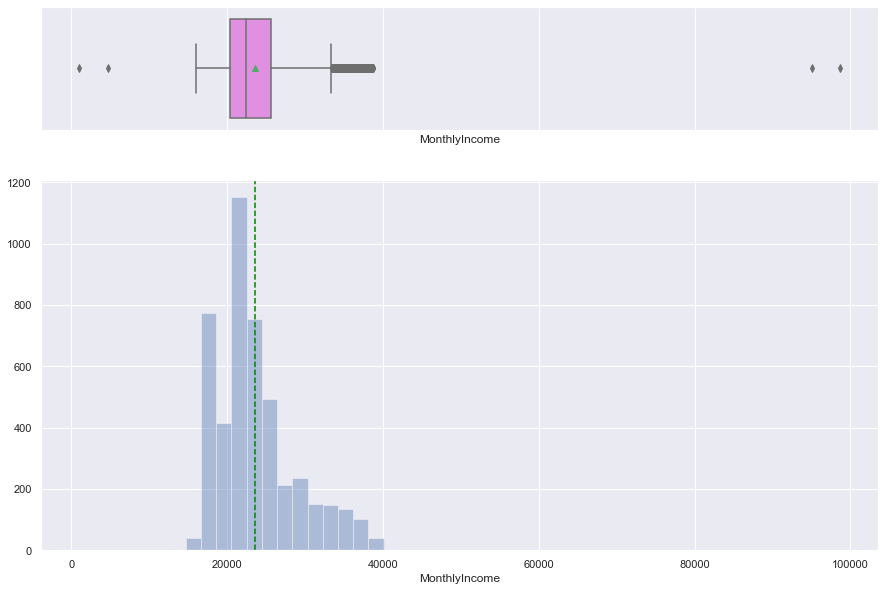

In [52]:
histogram_boxplot(working_df.MonthlyIncome)

In [53]:
print('mean', working_df.MonthlyIncome.mean(), 'median', working_df.MonthlyIncome.median())

mean 23619.85349087003 median 22347.0


In [54]:
# Compute Z scores
m_inc = working_df.MonthlyIncome
print(m_inc)

# calculate mean
mean = np.mean(m_inc) # calculate standard deviation
sd = np.std(m_inc)# determine a threhold

z = (m_inc - mean)/sd
print(z)

working_df['MonthlyIncomeZ'] = z
working_df


0       20993.0
1       20130.0
2       17090.0
3       17909.0
4       18468.0
         ...   
4883    26576.0
4884    21212.0
4885    31820.0
4886    20289.0
4887    24041.0
Name: MonthlyIncome, Length: 4888, dtype: float64
0      -0.488252
1      -0.648657
2      -1.213700
3      -1.061473
4      -0.957572
          ...   
4883    0.549457
4884   -0.447546
4885    1.524157
4886   -0.619104
4887    0.078278
Name: MonthlyIncome, Length: 4888, dtype: float64


,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,...,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins,MonthlyIncomeZ
0,1,41.000000,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Super Deluxe,...,Single,1.0,1,2,1,0.0,Manager,20993.0,2,-0.488252
1,0,49.000000,Company Invited,1,14.0,Salaried,Male,3,4.0,Super Deluxe,...,Divorced,2.0,0,3,1,2.0,Manager,20130.0,3,-0.648657
2,1,37.000000,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Multi,...,Single,7.0,1,3,0,0.0,Executive,17090.0,2,-1.213700
3,0,33.000000,Company Invited,1,9.0,Salaried,Female,2,3.0,Multi,...,Divorced,2.0,1,5,1,1.0,Executive,17909.0,1,-1.061473
4,0,37.622265,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Multi,...,Divorced,1.0,0,5,1,0.0,Executive,18468.0,NaN,-0.957572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,1,49.000000,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Super Deluxe,...,Unmarried,2.0,1,1,1,1.0,Manager,26576.0,3,0.549457
4884,1,28.000000,Company Invited,1,31.0,Salaried,Male,4,5.0,Multi,...,Single,3.0,1,3,1,2.0,Executive,21212.0,1,-0.447546
4885,1,52.000000,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,...,Married,7.0,0,1,1,3.0,Senior Manager,31820.0,3,1.524157
4886,1,19.000000,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Multi,...,Single,3.0,0,5,0,2.0,Executive,20289.0,0,-0.619104


In [55]:
no_outlier_mean_m_inc = working_df[abs(working_df.MonthlyIncomeZ) < 3].mean()['MonthlyIncome']
no_outlier_median_m_inc = working_df[abs(working_df.MonthlyIncomeZ) < 3].median()['MonthlyIncome']

print('mean without outlier',no_outlier_mean_m_inc, 'median', no_outlier_median_m_inc)

mean without outlier 23597.304235648247 median 22347.0


In [56]:
print(f'No of rows with outlier {working_df[abs(working_df.MonthlyIncomeZ) >= 3].shape[0]}')

No of rows with outlier 4


In [57]:
x=imp_median.fit_transform(working_df[['MonthlyIncome']])
s=pd.Series(x.flatten(),index=working_df.index)
print(s)
working_df['MonthlyIncome'] = s

0       20993.0
1       20130.0
2       17090.0
3       17909.0
4       18468.0
         ...   
4883    26576.0
4884    21212.0
4885    31820.0
4886    20289.0
4887    24041.0
Length: 4888, dtype: float64


In [58]:
make_summary_cols(working_df)

,nuniques,dtypes,nulls,isnumeric_column,probably_categorical
ProdTaken,2,int64,0,True,True
OwnCar,2,int64,0,True,True
CityTier,3,int64,0,True,True
PitchSatisfactionScore,5,int64,0,True,True
Passport,2,int64,0,True,True
NumberOfPersonVisited,5,int64,0,True,True
NumberOfChildrenVisited,4,float64,0,True,True
NumberOfTrips,12,float64,0,True,True
PreferredPropertyStar,3,float64,0,True,True
MonthlyIncome,2475,float64,0,True,False


<font color=blue>
<li> MonthlyIncome has outliers (only 4 rows) which I identify with z scores - not treated as tree models are robust to outliers
<li> Filling NaN with median (median is same with or without outliers and mean is slightly different)

<font color=blue>
<h3>NaN in Duration of Pitch

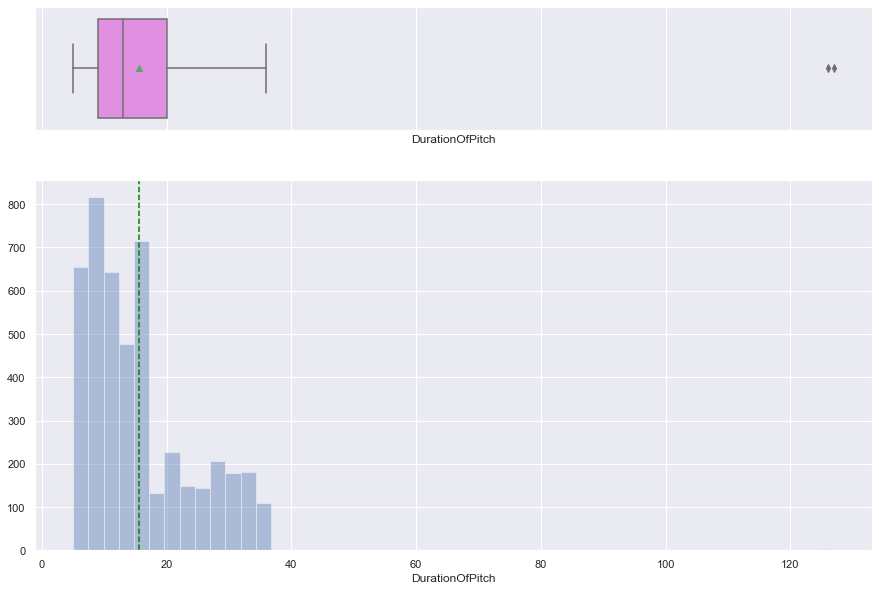

In [59]:
histogram_boxplot(working_df.DurationOfPitch)

In [60]:
print('mean', working_df.DurationOfPitch.mean(), 'median', working_df.DurationOfPitch.median())

mean 15.490834591330602 median 13.0


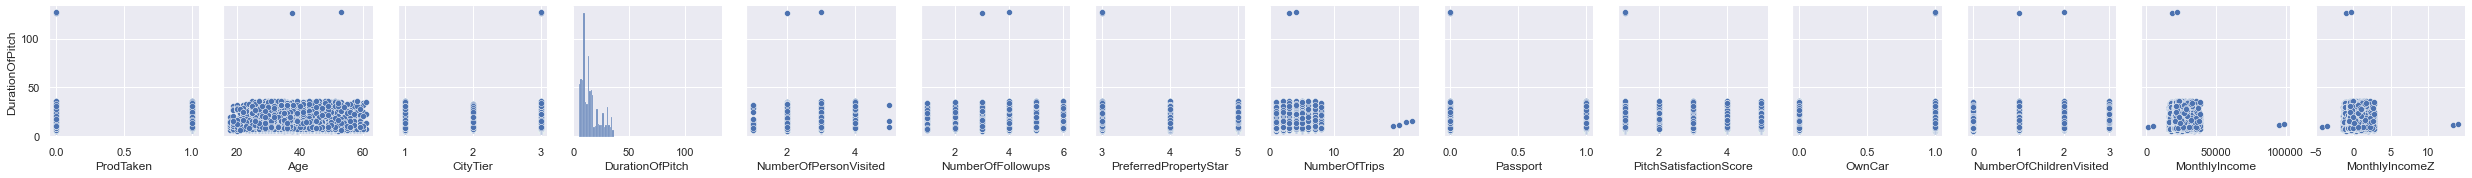

In [61]:
sns.pairplot(working_df, y_vars=['DurationOfPitch'])

In [62]:
working_df['DurationBins']=pd.qcut(working_df.DurationOfPitch,5, labels=range(0,5))
working_df.groupby('DurationBins').mean()

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisited,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome,MonthlyIncomeZ
DurationBins,,,,,,,,,,,,,,
0,0.148785,38.499306,1.580972,7.014170,2.787449,3.629555,3.606275,3.053644,0.257085,3.028340,0.610324,1.079960,23389.126518,-0.034499
1,0.172747,37.990369,1.700644,9.701717,2.989270,3.863734,3.530043,3.451717,0.286481,3.136266,0.623391,1.268240,24416.068670,0.160343
2,0.168085,37.593902,1.615957,13.634043,2.893617,3.684043,3.590426,3.330851,0.284043,3.032979,0.629787,1.195745,23516.287234,-0.014284
3,0.225113,36.886905,1.704751,18.494344,3.020362,3.797511,3.624434,3.209276,0.324661,3.169683,0.641403,1.300905,23661.739819,0.014313
4,0.235162,37.862264,1.634938,29.892497,2.977604,3.709966,3.544233,3.236282,0.318029,3.035834,0.589026,1.207167,23595.592385,0.001352


In [63]:
# Compute Z scores
dur = working_df.DurationOfPitch
print(dur)

# calculate mean
mean = np.mean(dur) # calculate standard deviation
sd = np.std(dur)# determine a threhold

z = (dur - mean)/sd
print(z)

working_df['DurationOfPitchZ'] = z
working_df

0        6.0
1       14.0
2        8.0
3        9.0
4        8.0
        ... 
4883     9.0
4884    31.0
4885    17.0
4886    16.0
4887    14.0
Name: DurationOfPitch, Length: 4888, dtype: float64
0      -1.114115
1      -0.175007
2      -0.879338
3      -0.761949
4      -0.879338
          ...   
4883   -0.761949
4884    1.820597
4885    0.177159
4886    0.059770
4887   -0.175007
Name: DurationOfPitch, Length: 4888, dtype: float64


,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,...,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,Designation,MonthlyIncome,AgeBins,MonthlyIncomeZ,DurationBins,DurationOfPitchZ
0,1,41.000000,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Super Deluxe,...,1,2,1,0.0,Manager,20993.0,2,-0.488252,0,-1.114115
1,0,49.000000,Company Invited,1,14.0,Salaried,Male,3,4.0,Super Deluxe,...,0,3,1,2.0,Manager,20130.0,3,-0.648657,2,-0.175007
2,1,37.000000,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Multi,...,1,3,0,0.0,Executive,17090.0,2,-1.213700,0,-0.879338
3,0,33.000000,Company Invited,1,9.0,Salaried,Female,2,3.0,Multi,...,1,5,1,1.0,Executive,17909.0,1,-1.061473,1,-0.761949
4,0,37.622265,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Multi,...,0,5,1,0.0,Executive,18468.0,NaN,-0.957572,0,-0.879338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,1,49.000000,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Super Deluxe,...,1,1,1,1.0,Manager,26576.0,3,0.549457,1,-0.761949
4884,1,28.000000,Company Invited,1,31.0,Salaried,Male,4,5.0,Multi,...,1,3,1,2.0,Executive,21212.0,1,-0.447546,4,1.820597
4885,1,52.000000,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,...,0,1,1,3.0,Senior Manager,31820.0,3,1.524157,3,0.177159
4886,1,19.000000,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Multi,...,0,5,0,2.0,Executive,20289.0,0,-0.619104,3,0.059770


In [64]:
no_outlier_mean_dur = working_df[abs(working_df.DurationOfPitchZ) < 3].mean()['DurationOfPitch']
no_outlier_median_dur = working_df[abs(working_df.DurationOfPitchZ) < 3].median()['DurationOfPitch']

print('mean without outlier',no_outlier_mean_dur, 'median', no_outlier_median_dur)

mean without outlier 15.442934196332255 median 13.0


In [65]:
print(f'No of rows with outlier {working_df[abs(working_df.DurationOfPitchZ) >= 3].shape[0]}')

No of rows with outlier 2


In [66]:
x=imp_median.fit_transform(working_df[['DurationOfPitch']])
s=pd.Series(x.flatten(),index=working_df.index)
print(s)
working_df['DurationOfPitch'] = s

0        6.0
1       14.0
2        8.0
3        9.0
4        8.0
        ... 
4883     9.0
4884    31.0
4885    17.0
4886    16.0
4887    14.0
Length: 4888, dtype: float64


<font color='blue'>
<li> Duration has outliers identified by z score (2 rows), again not dropped or treated as tree models are robust to outliers
<li> Using median to replace nan - median is same with or without outliers -> no identified correlation with any other variable

<font color = blue>
    <h3>Outliers in Categorical Columns

In [67]:
data['NumberOfPersonVisited'].value_counts()

3    2402
2    1418
4    1026
1      39
5       3
Name: NumberOfPersonVisited, dtype: int64

In [68]:
data['Occupation'].value_counts()

Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: Occupation, dtype: int64

In [69]:
working_df = working_df[working_df.Occupation!='Free Lancer']

<font color=blue>
    <li>1 and 5 are outliers in NumberOfPersonsVisited; Free Lancer is an outlier in Occupation</li>
<li>Ignoring for NumberOfPersonVisited as anyway that variable is encoded as int and is an ordinal categorical variable (tree models are robust to outliers)</li>
    <li>For Occupation = Free Lancer, I prefer to drop it (even though both rows have ProdTaken=1) since its too small a dataset to use and while marginal, it does seem to help precision for some of the models (discussed below)


<font color = blue>
    <h3>Cleanup columns

In [70]:
working_df.columns

Index(['ProdTaken', 'Age', 'PreferredLoginDevice', 'CityTier',
       'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfPersonVisited',
       'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar',
       'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore',
       'OwnCar', 'NumberOfChildrenVisited', 'Designation', 'MonthlyIncome',
       'AgeBins', 'MonthlyIncomeZ', 'DurationBins', 'DurationOfPitchZ'],
      dtype='object')

In [71]:
working_df.drop(['AgeBins','DurationBins','MonthlyIncomeZ', 'DurationOfPitchZ'],axis=1,inplace=True)
working_df.columns

Index(['ProdTaken', 'Age', 'PreferredLoginDevice', 'CityTier',
       'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfPersonVisited',
       'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar',
       'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore',
       'OwnCar', 'NumberOfChildrenVisited', 'Designation', 'MonthlyIncome'],
      dtype='object')

In [72]:
working_df.drop('Designation', axis=1, inplace=True)

In [73]:
working_df

,ProdTaken,Age,PreferredLoginDevice,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisited,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisited,MonthlyIncome
0,1,41.000000,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Super Deluxe,3.0,Single,1.0,1,2,1,0.0,20993.0
1,0,49.000000,Company Invited,1,14.0,Salaried,Male,3,4.0,Super Deluxe,4.0,Divorced,2.0,0,3,1,2.0,20130.0
3,0,33.000000,Company Invited,1,9.0,Salaried,Female,2,3.0,Multi,3.0,Divorced,2.0,1,5,1,1.0,17909.0
4,0,37.622265,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Multi,4.0,Divorced,1.0,0,5,1,0.0,18468.0
5,0,32.000000,Company Invited,1,8.0,Salaried,Male,3,3.0,Multi,3.0,Single,1.0,0,5,1,1.0,18068.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,1,49.000000,Self Enquiry,3,9.0,Small Business,Male,3,5.0,Super Deluxe,4.0,Unmarried,2.0,1,1,1,1.0,26576.0
4884,1,28.000000,Company Invited,1,31.0,Salaried,Male,4,5.0,Multi,3.0,Single,3.0,1,3,1,2.0,21212.0
4885,1,52.000000,Self Enquiry,3,17.0,Salaried,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,31820.0
4886,1,19.000000,Self Enquiry,3,16.0,Small Business,Male,3,4.0,Multi,3.0,Single,3.0,0,5,0,2.0,20289.0


<font color=blue>
<li> Dropped columns created for data exporation and cleanup
<li> Dropped Designation as exactly predicted by ProductPitched

<font color=blue>
<h3> One Hot For Categorical non numeric columns

In [74]:
x = make_summary_cols(working_df)
display(x)
categorical_columns = list(x[x['dtypes']=='object'].index)
print(categorical_columns)
del(x)

,nuniques,dtypes,nulls,isnumeric_column,probably_categorical
ProdTaken,2,int64,0,True,True
OwnCar,2,int64,0,True,True
PitchSatisfactionScore,5,int64,0,True,True
CityTier,3,int64,0,True,True
Passport,2,int64,0,True,True
NumberOfPersonVisited,5,int64,0,True,True
NumberOfTrips,12,float64,0,True,True
PreferredPropertyStar,3,float64,0,True,True
NumberOfFollowups,6,float64,0,True,True
DurationOfPitch,34,float64,0,True,False


['ProductPitched', 'Gender', 'MaritalStatus', 'Occupation', 'PreferredLoginDevice']


In [75]:
model_df = pd.get_dummies(working_df, columns=categorical_columns, drop_first=True)
model_df.columns

Index(['ProdTaken', 'Age', 'CityTier', 'DurationOfPitch',
       'NumberOfPersonVisited', 'NumberOfFollowups', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisited', 'MonthlyIncome', 'ProductPitched_King',
       'ProductPitched_Multi', 'ProductPitched_Standard',
       'ProductPitched_Super Deluxe', 'Gender_Male', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'MaritalStatus_Unmarried',
       'Occupation_Salaried', 'Occupation_Small Business',
       'PreferredLoginDevice_Self Enquiry'],
      dtype='object')

<font color=blue>
<h2>Model Building
    <h3>Decision Tree, Bagging, Random Forest

In [76]:
random_state = 314159

In [77]:
X = model_df.drop(['ProdTaken'],axis=1)
y = model_df['ProdTaken']
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=random_state,stratify=y)
print(X_train.shape, X_test.shape)

(3420, 23) (1466, 23)


In [78]:
print(f'Ratio of 1 in data: {y.value_counts()[1]/y.count()}')
print(f'Ratio of 1 in train data: {y_train.value_counts()[1]/y_train.count()}')
print(f'Ratio of 1 in test data: {y_test.value_counts()[1]/y_test.count()}')

Ratio of 1 in data: 0.18788374948833403
Ratio of 1 in train data: 0.18801169590643274
Ratio of 1 in test data: 0.18758526603001363


In [79]:
dtree= DecisionTreeClassifier(criterion='gini',random_state=random_state, class_weight='balanced')
dtree

DecisionTreeClassifier(class_weight='balanced', random_state=314159)

In [80]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=314159)

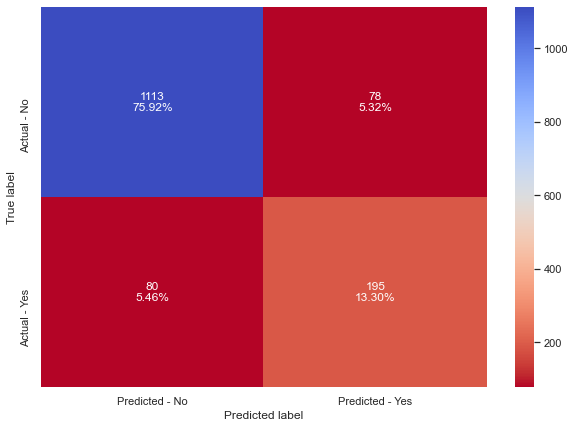

In [81]:
make_confusion_matrix(dtree, y_test, cmap='coolwarm_r')

In [82]:
get_accuracy_score(dtree)

Accuracy on training set :  1.0
Accuracy on test set :  0.8922237380627558


[1.0, 0.8922237380627558]

In [83]:
y_predict = dtree.predict(X_test)
cm=metrics.confusion_matrix( y_test, y_predict, labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]], columns = [i for i in ['Predicted - No','Predicted - Yes']])
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

In [84]:
def model_score_df(model, label='model', score_df=None):
    
        
    # Scores on Test Data
    y_predict = model.predict(X_test)
    
    
    TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_predict).ravel()
    TNR = TN/(TN+FP)
    FPR = 1-TNR

    x={'model_accuracy':metrics.accuracy_score(y_test, y_predict),
       'model_recall_sensitivity_TPR':metrics.recall_score(y_test, y_predict),
       'model_precision':metrics.precision_score(y_test, y_predict),
       'Specificity_TNR':TNR,
       'model_f1':metrics.f1_score(y_test, y_predict),
       'FPR': FPR}
    
    df1 = pd.DataFrame(x, index=[label+'-test']).T
    
    #display(df1)
    # Scores on Train Data
    y_predict = model.predict(X_train)
    
    TN, FP, FN, TP = metrics.confusion_matrix(y_train, y_predict).ravel()
    TNR = TN/(TN+FP)
    FPR = 1-TNR

    x={'model_accuracy':metrics.accuracy_score(y_train, y_predict),
       'model_recall_sensitivity_TPR':metrics.recall_score(y_train, y_predict),
       'model_precision':metrics.precision_score(y_train, y_predict),
       'Specificity_TNR':TNR,
       'model_f1':metrics.f1_score(y_train, y_predict),
       'FPR': FPR}
    
    df2 = pd.DataFrame(x, index=[label+'-train']).T
    #display(df2)
    
    df_1_2 = pd.merge(df1, df2, left_index=True, right_index=True)
    
    if score_df is None:
        score_df = df_1_2
    else:
        score_df = pd.merge(score_df, df_1_2, left_index=True, right_index=True)
    
    
    return score_df
    



In [85]:
score_df = model_score_df(dtree, 'DT')
score_df

,DT-test,DT-train
model_accuracy,0.892224,1.0
model_recall_sensitivity_TPR,0.709091,1.0
model_precision,0.714286,1.0
Specificity_TNR,0.934509,1.0
model_f1,0.711679,1.0
FPR,0.065491,0.0


<font color = blue>
    <li> dtree has done well but overfitting on training data


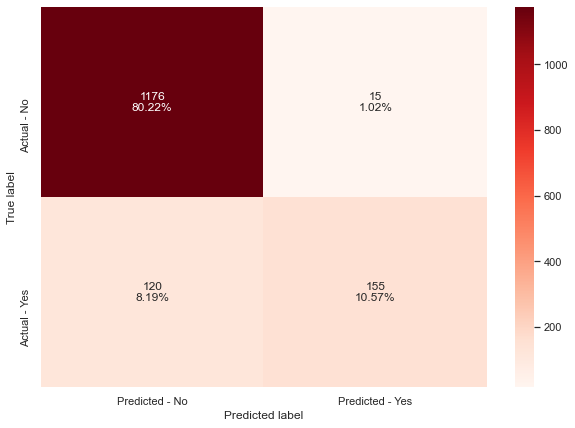

In [86]:
bagging = BaggingClassifier(random_state=random_state)
bagging.fit(X_train,y_train)
make_confusion_matrix(bagging, y_test, cmap='Reds')

In [87]:
get_accuracy_score(bagging)

Accuracy on training set :  0.9929824561403509
Accuracy on test set :  0.907912687585266


[0.9929824561403509, 0.907912687585266]

In [88]:
score_df = model_score_df(bagging, 'BG', score_df)
score_df

,DT-test,DT-train,BG-test,BG-train
model_accuracy,0.892224,1.0,0.907913,0.992982
model_recall_sensitivity_TPR,0.709091,1.0,0.563636,0.964230
model_precision,0.714286,1.0,0.911765,0.998390
Specificity_TNR,0.934509,1.0,0.987406,0.999640
model_f1,0.711679,1.0,0.696629,0.981013
FPR,0.065491,0.0,0.012594,0.000360


<font color=blue>
    <li>Bagging classifier performs better on test data in terms of accuracy and precision and has slightly lower overfitting (abeit with slightly lower recall)

In [89]:
rf = RandomForestClassifier(random_state=random_state,class_weight='balanced')
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=314159)

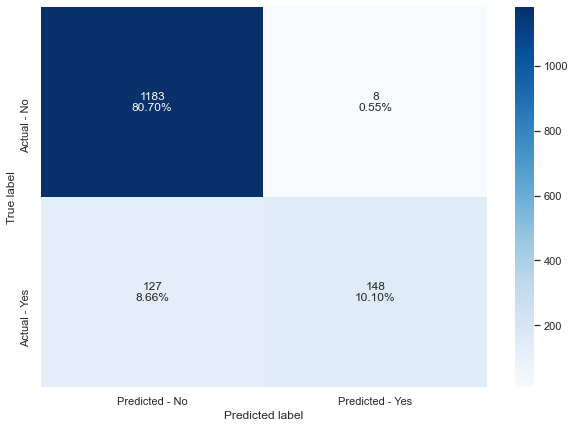

In [90]:
make_confusion_matrix(rf, y_test)

In [91]:
get_accuracy_score(rf)

Accuracy on training set :  1.0
Accuracy on test set :  0.907912687585266


[1.0, 0.907912687585266]

In [92]:
score_df = model_score_df(rf, 'RF', score_df)
score_df

,DT-test,DT-train,BG-test,BG-train,RF-test,RF-train
model_accuracy,0.892224,1.0,0.907913,0.992982,0.907913,1.0
model_recall_sensitivity_TPR,0.709091,1.0,0.563636,0.964230,0.538182,1.0
model_precision,0.714286,1.0,0.911765,0.998390,0.948718,1.0
Specificity_TNR,0.934509,1.0,0.987406,0.999640,0.993283,1.0
model_f1,0.711679,1.0,0.696629,0.981013,0.686775,1.0
FPR,0.065491,0.0,0.012594,0.000360,0.006717,0.0


<font color=blue>
    <li>RF has done well on acccuracy and precision while recall is lower on test data; but again has overfitting on training data

<font color=blue>
    <h3>Tuning Dtree, RF and Bagging


In [93]:
# Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(random_state=random_state)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,30), 
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.00001,0.0001,0.001,0.01,0.1], 
              'class_weight':['balanced', None]
             }


# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10,
                       min_impurity_decrease=1e-05, random_state=314159)

In [94]:
get_accuracy_score(dtree_estimator)

Accuracy on training set :  0.841812865497076
Accuracy on test set :  0.8376534788540245


[0.841812865497076, 0.8376534788540245]

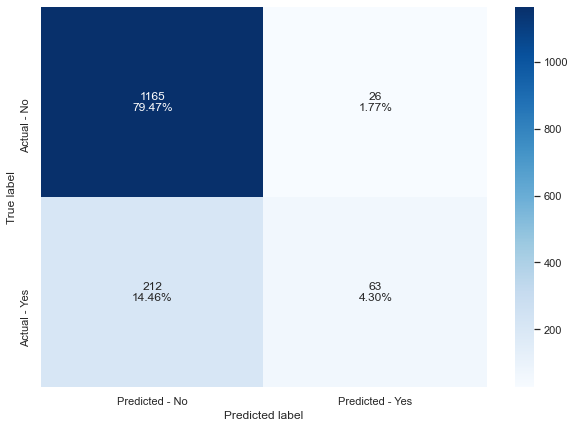

In [95]:
make_confusion_matrix(dtree_estimator, y_test)

In [96]:
score_df = model_score_df(dtree_estimator, "DT-tuned", score_df)
score_df

,DT-test,DT-train,BG-test,BG-train,RF-test,RF-train,DT-tuned-test,DT-tuned-train
model_accuracy,0.892224,1.0,0.907913,0.992982,0.907913,1.0,0.837653,0.841813
model_recall_sensitivity_TPR,0.709091,1.0,0.563636,0.964230,0.538182,1.0,0.229091,0.251944
model_precision,0.714286,1.0,0.911765,0.998390,0.948718,1.0,0.707865,0.729730
Specificity_TNR,0.934509,1.0,0.987406,0.999640,0.993283,1.0,0.978170,0.978394
model_f1,0.711679,1.0,0.696629,0.981013,0.686775,1.0,0.346154,0.374566
FPR,0.065491,0.0,0.012594,0.000360,0.006717,0.0,0.021830,0.021606


<font color=blue>
    <li>Greatly reduced overfitting and good accuracy but recall has crashed and precision is decent but not great

In [97]:
# grid search for bagging classifier
cl1 = DecisionTreeClassifier(random_state=random_state)
param_grid = {'base_estimator':[cl1],
              'n_estimators':[5,7,15,51,101],
              'max_features': [0.7,0.8,0.9,1]
             }

grid = GridSearchCV(BaggingClassifier(random_state=1,bootstrap=True), param_grid=param_grid, cv = 5,n_jobs=-1)
grid.fit(X_train, y_train)

bagging_estimator  = grid.best_estimator_
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=314159),
                  max_features=0.9, n_estimators=101, random_state=1)

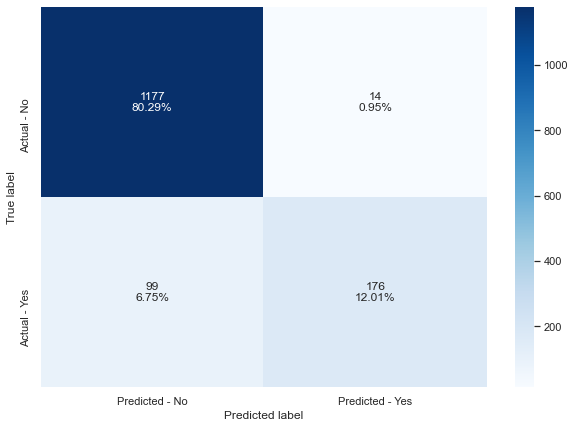

In [98]:
make_confusion_matrix(bagging_estimator, y_test)

In [99]:
get_accuracy_score(bagging_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.9229195088676672


[1.0, 0.9229195088676672]

In [100]:
score_df = model_score_df(bagging_estimator, 'BG-tuned', score_df)
score_df

,DT-test,DT-train,BG-test,BG-train,RF-test,RF-train,DT-tuned-test,DT-tuned-train,BG-tuned-test,BG-tuned-train
model_accuracy,0.892224,1.0,0.907913,0.992982,0.907913,1.0,0.837653,0.841813,0.922920,1.0
model_recall_sensitivity_TPR,0.709091,1.0,0.563636,0.964230,0.538182,1.0,0.229091,0.251944,0.640000,1.0
model_precision,0.714286,1.0,0.911765,0.998390,0.948718,1.0,0.707865,0.729730,0.926316,1.0
Specificity_TNR,0.934509,1.0,0.987406,0.999640,0.993283,1.0,0.978170,0.978394,0.988245,1.0
model_f1,0.711679,1.0,0.696629,0.981013,0.686775,1.0,0.346154,0.374566,0.756989,1.0
FPR,0.065491,0.0,0.012594,0.000360,0.006717,0.0,0.021830,0.021606,0.011755,0.0


<font color=blue>
    <li>Hypertuning hasnt helped bagging much - still over fitting

In [101]:
# Choose the type of classifier. 
rf_estimator = RandomForestClassifier(random_state=random_state,oob_score=True,bootstrap=True)

# Grid of parameters to choose from
parameters = {  
                'max_features': ['sqrt','log2','auto'],
                'min_samples_leaf': np.arange(1,15,5),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': list(np.linspace(10, 50, 10, dtype = int)),
                'class_weight':['balanced',None]}


# Run the grid search
grid_obj = GridSearchCV(rf_estimator, parameters,cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=45, oob_score=True,
                       random_state=314159)

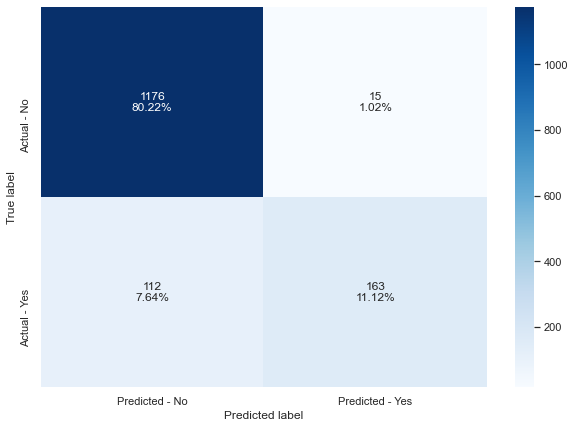

In [102]:
make_confusion_matrix(rf_estimator, y_test)

In [103]:
get_accuracy_score(rf_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.9133697135061392


[1.0, 0.9133697135061392]

In [104]:
score_df = model_score_df(rf_estimator, 'RF-tuned', score_df)
score_df

,DT-test,DT-train,BG-test,BG-train,RF-test,RF-train,DT-tuned-test,DT-tuned-train,BG-tuned-test,BG-tuned-train,RF-tuned-test,RF-tuned-train
model_accuracy,0.892224,1.0,0.907913,0.992982,0.907913,1.0,0.837653,0.841813,0.922920,1.0,0.913370,1.0
model_recall_sensitivity_TPR,0.709091,1.0,0.563636,0.964230,0.538182,1.0,0.229091,0.251944,0.640000,1.0,0.592727,1.0
model_precision,0.714286,1.0,0.911765,0.998390,0.948718,1.0,0.707865,0.729730,0.926316,1.0,0.915730,1.0
Specificity_TNR,0.934509,1.0,0.987406,0.999640,0.993283,1.0,0.978170,0.978394,0.988245,1.0,0.987406,1.0
model_f1,0.711679,1.0,0.696629,0.981013,0.686775,1.0,0.346154,0.374566,0.756989,1.0,0.719647,1.0
FPR,0.065491,0.0,0.012594,0.000360,0.006717,0.0,0.021830,0.021606,0.011755,0.0,0.012594,0.0


<font color=blue>
    <li>Here too tuning didnt help much - still overfitting

## Adaboost

In [105]:
abc = AdaBoostClassifier(random_state=random_state)
abc.fit(X_train,y_train)

AdaBoostClassifier(random_state=314159)

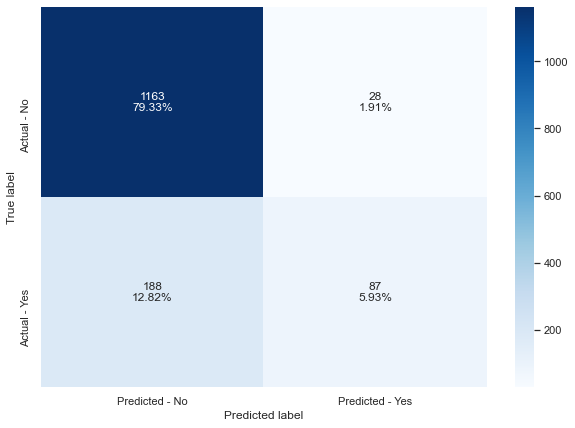

In [106]:
make_confusion_matrix(abc, y_test)

In [107]:
get_accuracy_score(abc)

Accuracy on training set :  0.8538011695906432
Accuracy on test set :  0.8526603001364257


[0.8538011695906432, 0.8526603001364257]

In [108]:
score_df = model_score_df(abc, 'ABC', score_df)
score_df

,DT-test,DT-train,BG-test,BG-train,RF-test,RF-train,DT-tuned-test,DT-tuned-train,BG-tuned-test,BG-tuned-train,RF-tuned-test,RF-tuned-train,ABC-test,ABC-train
model_accuracy,0.892224,1.0,0.907913,0.992982,0.907913,1.0,0.837653,0.841813,0.922920,1.0,0.913370,1.0,0.852660,0.853801
model_recall_sensitivity_TPR,0.709091,1.0,0.563636,0.964230,0.538182,1.0,0.229091,0.251944,0.640000,1.0,0.592727,1.0,0.316364,0.346812
model_precision,0.714286,1.0,0.911765,0.998390,0.948718,1.0,0.707865,0.729730,0.926316,1.0,0.915730,1.0,0.756522,0.735974
Specificity_TNR,0.934509,1.0,0.987406,0.999640,0.993283,1.0,0.978170,0.978394,0.988245,1.0,0.987406,1.0,0.976490,0.971192
model_f1,0.711679,1.0,0.696629,0.981013,0.686775,1.0,0.346154,0.374566,0.756989,1.0,0.719647,1.0,0.446154,0.471459
FPR,0.065491,0.0,0.012594,0.000360,0.006717,0.0,0.021830,0.021606,0.011755,0.0,0.012594,0.0,0.023510,0.028808


<font color=blue>
    <li>Decent general performance - good accuracy and precision although recall is poor; no overfitting

## Gradient Boosting

In [109]:
gbc = GradientBoostingClassifier(random_state=random_state)
gbc.fit(X_train,y_train)


GradientBoostingClassifier(random_state=314159)

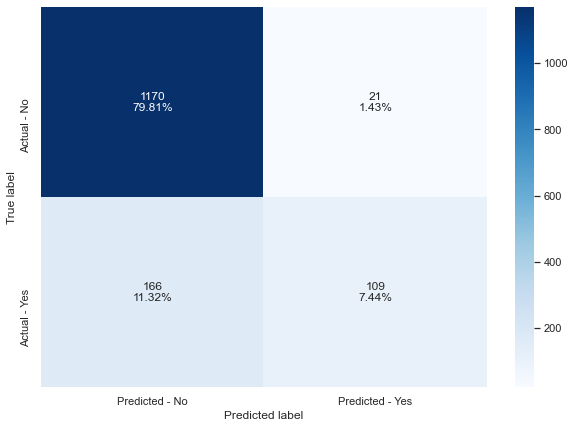

In [110]:
make_confusion_matrix(gbc, y_test)

In [111]:
get_accuracy_score(gbc)

Accuracy on training set :  0.8888888888888888
Accuracy on test set :  0.8724420190995907


[0.8888888888888888, 0.8724420190995907]

In [112]:
score_df = model_score_df(gbc, 'GBC', score_df)
score_df

,DT-test,DT-train,BG-test,BG-train,RF-test,RF-train,DT-tuned-test,DT-tuned-train,BG-tuned-test,BG-tuned-train,RF-tuned-test,RF-tuned-train,ABC-test,ABC-train,GBC-test,GBC-train
model_accuracy,0.892224,1.0,0.907913,0.992982,0.907913,1.0,0.837653,0.841813,0.922920,1.0,0.913370,1.0,0.852660,0.853801,0.872442,0.888889
model_recall_sensitivity_TPR,0.709091,1.0,0.563636,0.964230,0.538182,1.0,0.229091,0.251944,0.640000,1.0,0.592727,1.0,0.316364,0.346812,0.396364,0.482115
model_precision,0.714286,1.0,0.911765,0.998390,0.948718,1.0,0.707865,0.729730,0.926316,1.0,0.915730,1.0,0.756522,0.735974,0.838462,0.868347
Specificity_TNR,0.934509,1.0,0.987406,0.999640,0.993283,1.0,0.978170,0.978394,0.988245,1.0,0.987406,1.0,0.976490,0.971192,0.982368,0.983075
model_f1,0.711679,1.0,0.696629,0.981013,0.686775,1.0,0.346154,0.374566,0.756989,1.0,0.719647,1.0,0.446154,0.471459,0.538272,0.620000
FPR,0.065491,0.0,0.012594,0.000360,0.006717,0.0,0.021830,0.021606,0.011755,0.0,0.012594,0.0,0.023510,0.028808,0.017632,0.016925


<font color=blue>
    <li>Again no overfitting and better performance than Adaboost - accuracy, recall and precision all higher
    <li>good scores for accuracy and precision although recall is mediocre while better than in adaboost

## XGBoost

In [113]:
xgb = XGBClassifier(random_state=random_state,eval_metric='logloss')
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=314159, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

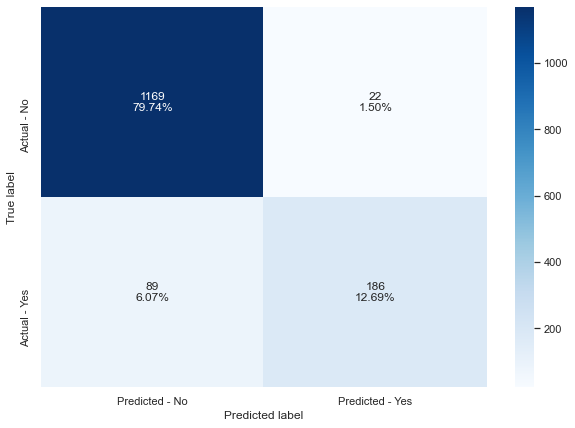

In [114]:
make_confusion_matrix(xgb, y_test)

In [115]:
get_accuracy_score(xgb)

Accuracy on training set :  0.9997076023391813
Accuracy on test set :  0.9242837653478854


[0.9997076023391813, 0.9242837653478854]

In [116]:
score_df = model_score_df(xgb, 'XGB', score_df)
score_df

,DT-test,DT-train,BG-test,BG-train,RF-test,RF-train,DT-tuned-test,DT-tuned-train,BG-tuned-test,BG-tuned-train,RF-tuned-test,RF-tuned-train,ABC-test,ABC-train,GBC-test,GBC-train,XGB-test,XGB-train
model_accuracy,0.892224,1.0,0.907913,0.992982,0.907913,1.0,0.837653,0.841813,0.922920,1.0,0.913370,1.0,0.852660,0.853801,0.872442,0.888889,0.924284,0.999708
model_recall_sensitivity_TPR,0.709091,1.0,0.563636,0.964230,0.538182,1.0,0.229091,0.251944,0.640000,1.0,0.592727,1.0,0.316364,0.346812,0.396364,0.482115,0.676364,0.998445
model_precision,0.714286,1.0,0.911765,0.998390,0.948718,1.0,0.707865,0.729730,0.926316,1.0,0.915730,1.0,0.756522,0.735974,0.838462,0.868347,0.894231,1.000000
Specificity_TNR,0.934509,1.0,0.987406,0.999640,0.993283,1.0,0.978170,0.978394,0.988245,1.0,0.987406,1.0,0.976490,0.971192,0.982368,0.983075,0.981528,1.000000
model_f1,0.711679,1.0,0.696629,0.981013,0.686775,1.0,0.346154,0.374566,0.756989,1.0,0.719647,1.0,0.446154,0.471459,0.538272,0.620000,0.770186,0.999222
FPR,0.065491,0.0,0.012594,0.000360,0.006717,0.0,0.021830,0.021606,0.011755,0.0,0.012594,0.0,0.023510,0.028808,0.017632,0.016925,0.018472,0.000000


<font color=blue>
    <li>Overfitting is present although test data performance is quite good

<font color=blue>
    <h3>Tuning Adaboost, Gradient and XG

In [ ]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=random_state)

# Grid of parameters to choose from
## add from article
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,1,0.1)
}

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

In [ ]:
make_confusion_matrix(abc_tuned, y_test)

In [ ]:
get_accuracy_score(abc_tuned)

In [ ]:
score_df = model_score_df(abc_tuned, 'ABC-tuned', score_df)
score_df

<font color=blue>
    <li>Better performance at the cost of some overfitting 

<font color=blue>
    <h4>Tuning Gradient Boosting

In [ ]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=random_state),random_state=random_state)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations


# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

In [ ]:
make_confusion_matrix(gbc_tuned, y_test)

In [ ]:
get_accuracy_score(gbc_tuned)

In [ ]:
score_df = model_score_df(gbc_tuned, 'GBC-tuned', score_df)
score_df

<font color=blue>
    <li>GBC tuned has done well on accuracy and precision with better performance on recall - no overfitting

<font color=blue>
    <h4>Tuning XGBoost

In [ ]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=random_state,eval_metric='logloss')

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(30,100,20),
    "subsample":[0.5,0.7,1],
    "learning_rate":[0.001,0.01,0.05,0.1],
    "colsample_bytree":[0.5,0.7,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

In [ ]:
make_confusion_matrix(xgb_tuned, y_test)

In [ ]:
get_accuracy_score(xgb_tuned)

In [ ]:
score_df = model_score_df(xgb_tuned, 'XGB-tuned', score_df)
score_df

<font color=blue>
    <li>Very good accuracy and precision performance on test data, recall is good too and does not seem to be overfitting on training data

<font color=blue>
    <h3>Stacking Classifier

In [ ]:
estimators=[('Decision Tree', dtree_tuned),('Random Forest', rf_tuned),
           ('Gradient Boosting', gbc_tuned)]
final_estimator=XGBClassifier(random_state=random_state,eval_metric='logloss')

In [ ]:
stacking_estimator=StackingClassifier(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_estimator.fit(X_train,y_train)

In [ ]:
make_confusion_matrix(stacking_estimator, y_test)

In [ ]:
get_accuracy_score(stacking_estimator)

In [ ]:
score_df = model_score_df(stacking_estimator, 'Stacking', score_df)
score_df

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(20,15))

feature_names = X_train.columns
importances = xgb.feature_importances_
indices = np.argsort(importances)

#plt.figure(figsize=(10,7))
plt.axes(axes[0,0])
plt.title('Feature Importances-XGB')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
#plt.show()

feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.axes(axes[0,1])
plt.title('Feature Importances-XGB tuned')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

feature_names = X_train.columns
importances = gbc.feature_importances_
indices = np.argsort(importances)

plt.axes(axes[1,0])
plt.title('Feature Importances-GBC')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

feature_names = X_train.columns
importances = gbc_tuned.feature_importances_
indices = np.argsort(importances)

plt.axes(axes[1,1])
plt.title('Feature Importances-GBC tuned')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

In [ ]:
score_df.T

<font color=blue>
    <h4>Models with no overfitting </h4>
    

In [ ]:
a = list(np.arange(1,score_df.shape[1],2))

x=score_df.T.iloc[a]
x = x[x.model_accuracy<=0.98]
display(x)

no_overf_models = list(x.index)
print(no_overf_models)

In [ ]:
b=[]
for a in no_overf_models:
    b.append(a.replace('train', 'test'))
    
score_df.T.loc[b]

<font color=blue>
<h2>Business implications</h2>
<h3>Best Model</h3>
<li>Models that do not overfit on training data are: DT-tuned, ABC, GBC, GBC tuned, and XGB tuned (defined as accuracy on train less than 0.98 - we note that for these models where accuracy >0.98, divergence between accuracy on test/ train data is quite large which also indicates overfitting)
<li>Of these, both the Gradient and XGBoost models do well when tuned - the XGB-tuned may be slightly overfitting based on high accuracy and ~6% more accuracy on train vs. test, but otherwise does quite well
<li>GBC-tuned also does well and no overfitting
<h3>Best Features</h3>
<li>most important features for XGB-tuned and GBC-tuned can be seen in the charts above
<li>While features are different for both models, most imp features are:
    <li>GBC-tuned: monthly income, age, passport, duration, prodpitched, marital, number of followups, city tier, no of trips
    <li>XGB-tuned: ProdPitched,passport, marital status, citytier, no of followups, prep prop star, age
        <h3>Metrics</h3>
        <li>Since dont want to waste marketing spend on likely negatives, precision is the important metric (of the trues model predicted, how many were actually positive)
         <li> having said that recall is imp too as dont want to miss likely positives
        <li> F1 score helps provide a balanced view between precision and recall
            <li>GBC tuned and XGB tuned do well on precision and F1 and are the best even for recall (ignoring overfitting models)
                <h3>Output if we dont drop rows with occupation=Free Lancer</h3>
      <li>We can see there is not much difference by dropping Free Lancer
  

<font color=blue>
<h4>Output with Data including Occupation=Free Lancer</h4>
<img src='output-without-dropping-occupation.jpg' height='50%' width='50%'></img>